<a href="https://colab.research.google.com/github/matbar97/Software-to-support-analysis-and-classification-of-lesions-on-X-ray-lung-images/blob/main/224_ResNet50_X_ray_dataset_250_per_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the workspace

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!nvidia-smi

Sun Aug 29 21:13:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    70W / 149W |    121MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle/"

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


# Lib loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization,\
GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.ensemble import BaggingClassifier
# from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import learning_curve
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, hinge_loss
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


# Set-up for X-ray data I (to get labels for SVM training)

In [ ]:
categories = ['bacterial_pneumonia', 'covid-19','normal','tuberculosis', 'viral_pneumonia']
data_dir = 'X-ray dataset 250 per class/train'
train_dir = 'X-ray dataset 250 per class/train'
train_dir = os.path.join(train_dir)
val_dir ='X-ray dataset 250 per class/val'
val_dir = os.path.join(val_dir)
test_dir ='X-ray dataset 250 per class/test'
test_dir =os.path.join(test_dir)

print(categories)

['bacterial_pneumonia', 'covid-19', 'normal', 'tuberculosis', 'viral_pneumonia']


In [ ]:
train_data = []
val_data = []
test_data=[]
for defects_id, sp in enumerate(categories):
    i = 0
    for file in os.listdir(os.path.join(train_dir, sp)):
            train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
            i += 1

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(train.head())

for defects_id, sp in enumerate(categories):
    i = 0
    for file in os.listdir(os.path.join(val_dir, sp)):
            val_data.append(['{}/{}'.format(sp, file), defects_id, sp])
            i += 1

val = pd.DataFrame(val_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(val.head())


for defects_id, sp in enumerate(categories):
    i = 0
    for file in os.listdir(os.path.join(test_dir, sp)):
            test_data.append(['{}/{}'.format(sp, file), defects_id, sp])
            i += 1

test = pd.DataFrame(test_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(test.head())

                               File  DiseaseID         Disease Type
0    bacterial_pneumonia/0 (2).jpeg          0  bacterial_pneumonia
1  bacterial_pneumonia/125 (2).jpeg          0  bacterial_pneumonia
2  bacterial_pneumonia/126 (2).jpeg          0  bacterial_pneumonia
3  bacterial_pneumonia/116 (2).jpeg          0  bacterial_pneumonia
4  bacterial_pneumonia/121 (2).jpeg          0  bacterial_pneumonia
                                              File  ...         Disease Type
0  bacterial_pneumonia/person139_bacteria_663.jpeg  ...  bacterial_pneumonia
1  bacterial_pneumonia/person140_bacteria_668.jpeg  ...  bacterial_pneumonia
2  bacterial_pneumonia/person130_bacteria_625.jpeg  ...  bacterial_pneumonia
3  bacterial_pneumonia/person137_bacteria_655.jpeg  ...  bacterial_pneumonia
4  bacterial_pneumonia/person130_bacteria_626.jpeg  ...  bacterial_pneumonia

[5 rows x 3 columns]
                                               File  ...         Disease Type
0  bacterial_pneumonia/person2

In [ ]:
SEED = 42

train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))  # Reset indices
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(train.head())

test = test.sample(frac=1, random_state=SEED)
test.index = np.arange(len(test))  # Reset indices
test = pd.DataFrame(test_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(test.head())

val = val.sample(frac=1, random_state=SEED)
val.index = np.arange(len(val))  # Reset indices
val = pd.DataFrame(val_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(val.head())


                               File  DiseaseID         Disease Type
0    bacterial_pneumonia/0 (2).jpeg          0  bacterial_pneumonia
1  bacterial_pneumonia/125 (2).jpeg          0  bacterial_pneumonia
2  bacterial_pneumonia/126 (2).jpeg          0  bacterial_pneumonia
3  bacterial_pneumonia/116 (2).jpeg          0  bacterial_pneumonia
4  bacterial_pneumonia/121 (2).jpeg          0  bacterial_pneumonia
                                               File  ...         Disease Type
0  bacterial_pneumonia/person275_bacteria_1294.jpeg  ...  bacterial_pneumonia
1  bacterial_pneumonia/person264_bacteria_1231.jpeg  ...  bacterial_pneumonia
2  bacterial_pneumonia/person281_bacteria_1326.jpeg  ...  bacterial_pneumonia
3  bacterial_pneumonia/person281_bacteria_1328.jpeg  ...  bacterial_pneumonia
4  bacterial_pneumonia/person293_bacteria_1379.jpeg  ...  bacterial_pneumonia

[5 rows x 3 columns]
                                              File  ...         Disease Type
0  bacterial_pneumonia/pe

# Initialize img size, epochs, lr, batch size

In [ ]:
IMAGE_SIZE = 224
EPOCHS = 100
lr = 5e-5
new_lr = 1e-5
BATCH_SIZE = 64

# Defining and loading Functions

In [ ]:
from keras import backend as K

def build_ImageNetModel(base_model):
  K.clear_session()

  NUM_CLASSES = len(categories)

  baseModel = base_model.output
  headModel = Flatten(name="flatten")(baseModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(256, activation="relu")(headModel)
  headModel = Dropout(0.5, seed=42)(headModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(128, activation="relu")(headModel)
  headModel = Dropout(0.5, seed=42)(headModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(64, activation="relu")(headModel)
  headModel = Dropout(0.5, seed=42)(headModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(NUM_CLASSES, activation="softmax")(headModel)

  model = Model(inputs=base_model.input, outputs=headModel)
  model.summary()
  return model

In [ ]:
def plot_acc(H, N, title):
	plt.style.use("ggplot")
	plt.figure(figsize=(10,10))
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title(title)
	plt.xlabel("Epoch #")
	plt.ylabel("Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(title)

In [ ]:
def plot_loss(H, N, title):
	plt.style.use("ggplot")
	plt.figure(figsize=(10,10))
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.title(title)
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	plt.savefig(title)

In [ ]:
def plot_confusion_matrix(model_name, y_test, y_pred, classes, normalize= False):

  cm = confusion_matrix(y_test, y_pred)
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.figure(figsize=(5.5, 5.5))
  plt.title((model_name), fontsize=9)
  ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=classes, yticklabels=classes)
  ax.set_ylabel('Actual', fontsize=13)
  ax.set_xlabel('Predicted', fontsize=13)
  tick_marks = np.arange(len(classes))
  ax.set_xticks(tick_marks, classes)
  ax.set_yticks(tick_marks, classes)
  plt.tight_layout()

  plt.show()

In [ ]:
def plot_ROC(y_test,y_score, n_classes, title):
  lw = 2

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(1, figsize=(9, 9))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(categories[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([-0.005, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()


  # Zoom in view of the upper left corner.
  plt.figure(2, figsize=(9, 9))
  plt.xlim(-0.02, 0.4)
  plt.ylim(0.8, 1.01)
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(categories[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

  return None

In [ ]:
def plot_ROC_SVM(X_train,y_train,X_test,y_test, y_score,
                            n_classes, class_labels, title, cv):

    lw = 2
    # Binarize (oneVSall) the multiclass predictions, for ROC curve plotting purposes
    y_train_binarized = label_binarize(y_train, classes=class_labels)
    y_test = label_binarize(y_test, classes=class_labels)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for cl in range(n_classes):
        fpr[cl], tpr[cl], _ = roc_curve(y_test[:, cl], y_score[:, cl])        
        roc_auc[cl] = auc(fpr[cl], tpr[cl])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1, figsize=(9, 9))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(categories[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


    # Zoom in view of the upper left corner.
    plt.figure(2, figsize=(9, 9))
    plt.xlim(-0.02, 0.4)
    plt.ylim(0.8, 1.01)
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(categories[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Representative Image')
    b = cv2.resize(a, (512,512))
    plt.imshow(b)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

In [ ]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols)
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(train_dir, defect_files[n])
            image = cv2.imread(image_path)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].set_title(defect_files[n], fontsize = 10)
            ax[i, j].imshow(image)
            n += 1

In [ ]:
def plot_defects_1(defect_types, rows, cols):
    fig = plt.figure() 
    ax = plt.subplot()
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0

    image_path = os.path.join(train_dir, defect_files[n])
    image = cv2.imread(image_path)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(defect_files[n], fontsize = 10)
    ax.imshow(image)
    n += 1

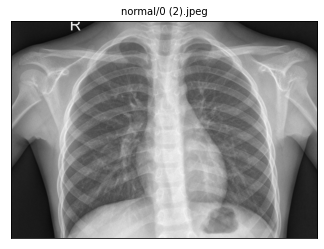

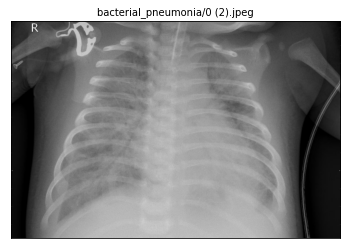

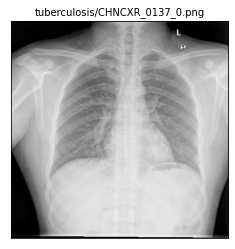

In [ ]:
# Displays first 1 images of class from training set
plot_defects_1("covid-19", 1, 1)
plot_defects_1("normal", 1, 1)
plot_defects_1("bacterial_pneumonia", 1, 1)
plot_defects_1("viral_pneumonia", 1, 1)
plot_defects_1("tuberculosis", 1, 1)

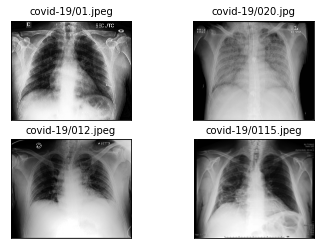

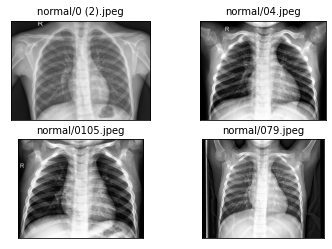

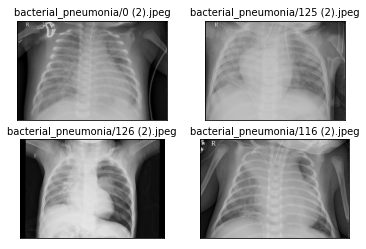

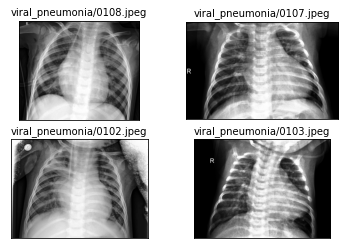

In [ ]:
# Displays first n images of class from training set
plot_defects("covid-19", 2, 2)
plot_defects("normal", 2, 2)
plot_defects("bacterial_pneumonia", 2, 2)
plot_defects("viral_pneumonia", 2, 2)
plot_defects("tuberculosis", 2, 2)

# Data loading from pickle saved files

In [ ]:
# rgb values / 255
import pickle as pkl

#to load it
# with open("train_255_224.pkl", "rb") as f:
#     X_train_255, Y_train = pkl.load(f)

# with open("val_255_224.pkl", "rb") as f:
#     X_val_255, Y_val = pkl.load(f)    
    
with open("test_255_224.pkl", "rb") as f:
    X_test_255, Y_test = pkl.load(f)

In [ ]:
## normalized data (0-1)

import pickle as pkl

#to load it
# with open("train_224.pkl", "rb") as f:
#     X_train, Y_train = pkl.load(f)

# with open("val_224.pkl", "rb") as f:
#     X_val, Y_val = pkl.load(f)
        
with open("test_224.pkl", "rb") as f:
    X_test, Y_test = pkl.load(f)

In [ ]:
# /255 divided + clahe

import pickle as pkl

#to load it
# with open("train_CLAHE_255_224.pkl", "rb") as f:
#     X_train_255_CLAHE, Y_train = pkl.load(f)

# with open("val_CLAHE_255_224.pkl", "rb") as f:
#     X_val_255_CLAHE, Y_val = pkl.load(f)    
    
with open("test_CLAHE_255_224.pkl", "rb") as f:
    X_test_255_CLAHE, Y_test = pkl.load(f)

In [ ]:
## normalized data (0-1 vals) + CLAHE preprocessing

import pickle as pkl

#to load it
# with open("train_CLAHE_NORMALIZED_224.pkl", "rb") as f:
#     X_train_CLAHE, Y_train = pkl.load(f)

# with open("val_CLAHE_NORMALIZED_224.pkl", "rb") as f:
#     X_val_CLAHE, Y_val = pkl.load(f)    
    
with open("test_CLAHE_NORMALIZED_224.pkl", "rb") as f:
    X_test_CLAHE, Y_test = pkl.load(f)

#Data for tuning from pickle saved files

In [ ]:
# rgb values / 255
import pickle as pkl

#to load it
with open("train_255_bigger.pkl", "rb") as f:
    X_train_255_ft, Y_train_ft = pkl.load(f)

with open("val_255_bigger.pkl", "rb") as f:
    X_val_255_ft, Y_val_ft = pkl.load(f)    
    
with open("test_255_224.pkl", "rb") as f:
    X_test_255_ft, Y_test_ft = pkl.load(f)

In [ ]:
## normalized data (0-1)

import pickle as pkl

#to load it
with open("train_bigger.pkl", "rb") as f:
    X_train_ft, Y_train_ft = pkl.load(f)

with open("val_bigger.pkl", "rb") as f:
    X_val_ft, Y_val_ft = pkl.load(f)
        
with open("test_224.pkl", "rb") as f:
    X_test_ft, Y_test_ft = pkl.load(f)

In [ ]:
# /255 divided + clahe

import pickle as pkl

#to load it
with open("train_CLAHE_255_bigger.pkl", "rb") as f:
    X_train_255_CLAHE_ft, Y_train_ft = pkl.load(f)

with open("val_CLAHE_255_bigger.pkl", "rb") as f:
    X_val_255_CLAHE_ft, Y_val_ft = pkl.load(f)    
    
with open("test_CLAHE_255_224.pkl", "rb") as f:
    X_test_255_CLAHE_ft, Y_test_ft = pkl.load(f)

In [ ]:
## normalized data (0-1 vals) + CLAHE preprocessing

import pickle as pkl

#to load it
with open("train_CLAHE_NORMALIZED_bigger.pkl", "rb") as f:
    X_train_CLAHE_ft, Y_train_ft = pkl.load(f)

with open("val_CLAHE_NORMALIZED_bigger.pkl", "rb") as f:
    X_val_CLAHE_ft, Y_val_ft = pkl.load(f)    
    
with open("test_CLAHE_NORMALIZED_224.pkl", "rb") as f:
    X_test_CLAHE_ft, Y_test_ft = pkl.load(f)

# NO AUGMENATION on data divided by 255

In [ ]:
model = build_ImageNetModel(ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True
# lr = 2e-5
optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('ResNet50 data scaled by 255.h5', verbose=2
                             ,save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Fits the model on batches
hist = model.fit(X_train_255, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255, Y_val)
                 )

Epoch 1/100
15/15 [==============================] - 42s 393ms/step - loss: 1.9841 - accuracy: 0.2401 - val_loss: 1.6905 - val_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.69051, saving model to ResNet50 data scaled by 255.h5
Epoch 2/100
15/15 [==============================] - 4s 220ms/step - loss: 1.6488 - accuracy: 0.3471 - val_loss: 1.8467 - val_accuracy: 0.2880

Epoch 00002: val_loss did not improve from 1.69051
Epoch 3/100
15/15 [==============================] - 3s 217ms/step - loss: 1.6142 - accuracy: 0.3727 - val_loss: 2.0089 - val_accuracy: 0.2400

Epoch 00003: val_loss did not improve from 1.69051
Epoch 4/100
15/15 [==============================] - 3s 226ms/step - loss: 1.5250 - accuracy: 0.3795 - val_loss: 1.8868 - val_accuracy: 0.2320

Epoch 00004: val_loss did not improve from 1.69051
Epoch 5/100
15/15 [==============================] - 3s 221ms/step - loss: 1.3473 - accuracy: 0.4935 - val_loss: 1.8364 - val_accuracy: 0.2800

Epoch 00005: val_loss did n

In [ ]:
del model
model = load_model('ResNet50 data scaled by 255.h5')

final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

4/4 [==============================] - 3s 546ms/step - loss: 0.4880 - accuracy: 0.8560
Final Loss: 0.4879767596721649, Final Accuracy: 0.8560000061988831
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.83      0.76      0.79        25
           covid-19       0.96      0.96      0.96        25
             normal       0.77      0.96      0.86        25
       tuberculosis       0.89      1.00      0.94        25
    viral_pneumonia       0.83      0.60      0.70        25

           accuracy                           0.86       125
          macro avg       0.86      0.86      0.85       125
       weighted avg       0.86      0.86      0.85       125



Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


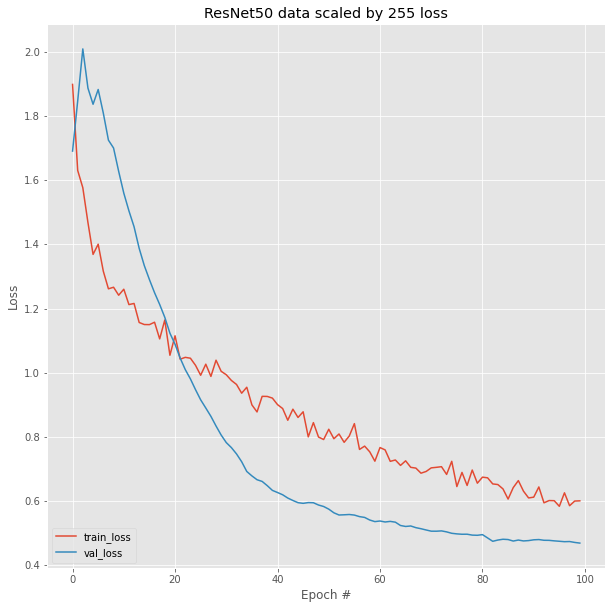

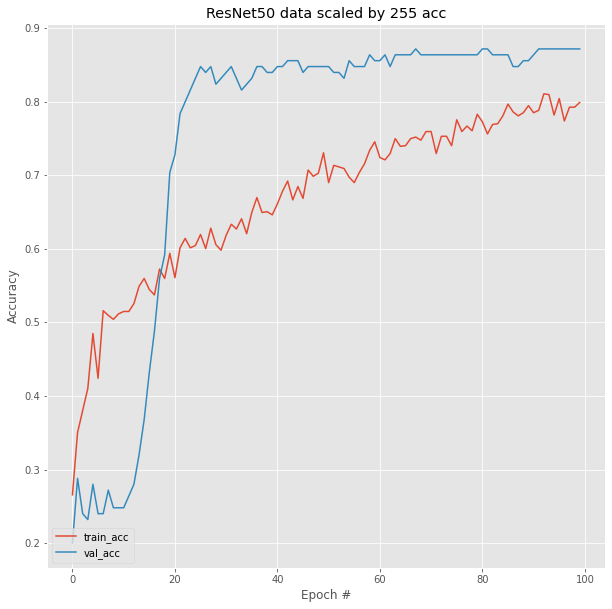

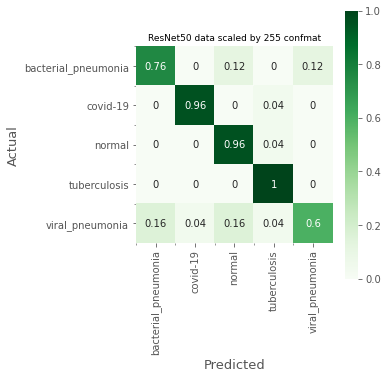

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'ResNet50 data scaled by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'ResNet50 data scaled by 255 acc')
plot_confusion_matrix('ResNet50 data scaled by 255 confmat',Y_true, predIdxs, categories, len(categories))

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


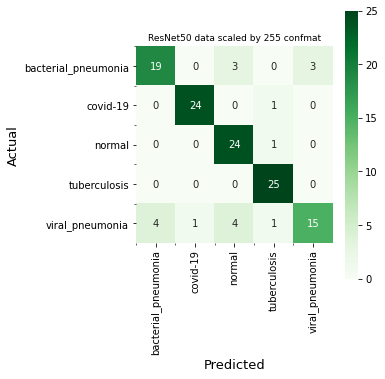

(125, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


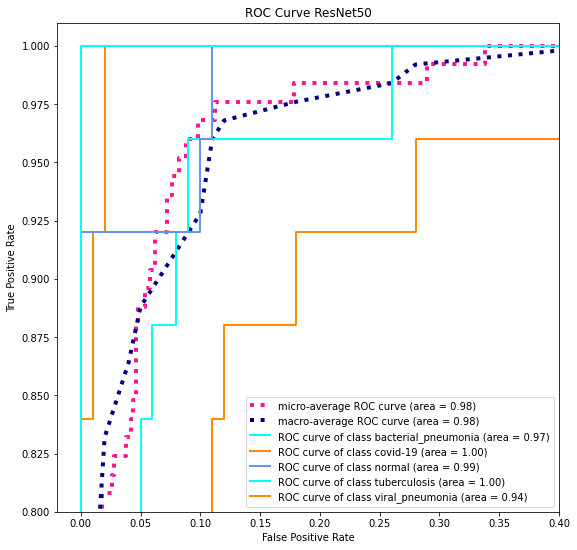

In [ ]:
plot_confusion_matrix('ResNet50 data scaled by 255 confmat',Y_true, predIdxs, categories)
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
print(predIdxs.shape)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve ResNet50')

#FineTuning on data divided by 255

In [ ]:
model = load_model('ResNet50 data scaled by 255.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[165:]:
    layer.trainable = True

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(new_lr)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned ResNet50 data scaled by 255.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train_255_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_ft, Y_val_ft))

model
Epoch 1/100
37/37 [==============================] - 48s 332ms/step - loss: 1.2415 - accuracy: 0.5359 - val_loss: 1.5591 - val_accuracy: 0.2967

Epoch 00001: val_loss improved from inf to 1.55909, saving model to FineTuned ResNet50 data scaled by 255.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 10s 251ms/step - loss: 0.9961 - accuracy: 0.6173 - val_loss: 4.4280 - val_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.55909
Epoch 3/100
37/37 [==============================] - 9s 247ms/step - loss: 0.9265 - accuracy: 0.6580 - val_loss: 6.5352 - val_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.55909
Epoch 4/100
37/37 [==============================] - 9s 247ms/step - loss: 0.8444 - accuracy: 0.6866 - val_loss: 7.2854 - val_accuracy: 0.2000

Epoch 00004: val_loss did not improve from 1.55909
Epoch 5/100
37/37 [==============================] - 9s 246ms/step - loss: 0.8108 - accuracy: 0.6965 - val_loss: 5.7698 - val_accuracy: 0.2200

Epoch 00005: val_loss did not improve from 1.55909
Epoch 6/100
37/37 [==============================] - 9s 245ms/step - loss: 0.7798 - accuracy: 0.7059 - val_loss: 4.5521 - val_accuracy: 0.2700

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951501e

In [ ]:
del model
model = load_model('FineTuned ResNet50 data scaled by 255.h5')
final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning")
Y_pred = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred,target_names=categories
))

4/4 [==============================] - 3s 500ms/step - loss: 0.3474 - accuracy: 0.9360
Final Loss: 0.3473900258541107, Final Accuracy: 0.9359999895095825
[INFO] evaluating after fine tuning
                     precision    recall  f1-score   support

bacterial_pneumonia       0.85      0.92      0.88        25
           covid-19       1.00      1.00      1.00        25
             normal       0.89      1.00      0.94        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.95      0.76      0.84        25

           accuracy                           0.94       125
          macro avg       0.94      0.94      0.93       125
       weighted avg       0.94      0.94      0.93       125



Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


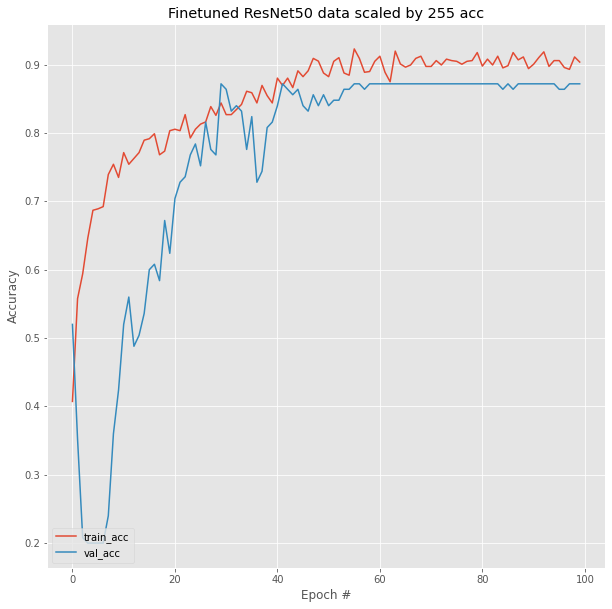

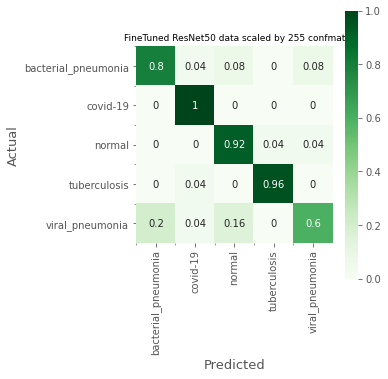

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned ResNet50 data scaled by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned ResNet50 data scaled by 255 acc')
plot_confusion_matrix('FineTuned ResNet50 data scaled by 255 confmat',Y_true, Y_pred, categories)

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


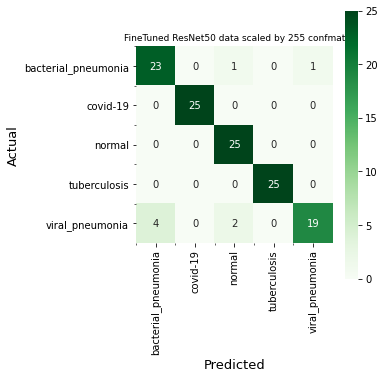

In [ ]:
plot_confusion_matrix('FineTuned ResNet50 data scaled by 255 confmat',Y_true, Y_pred, categories)

(125, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


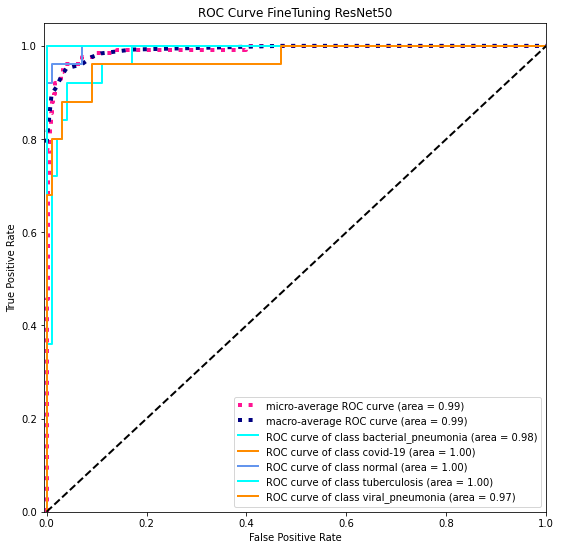

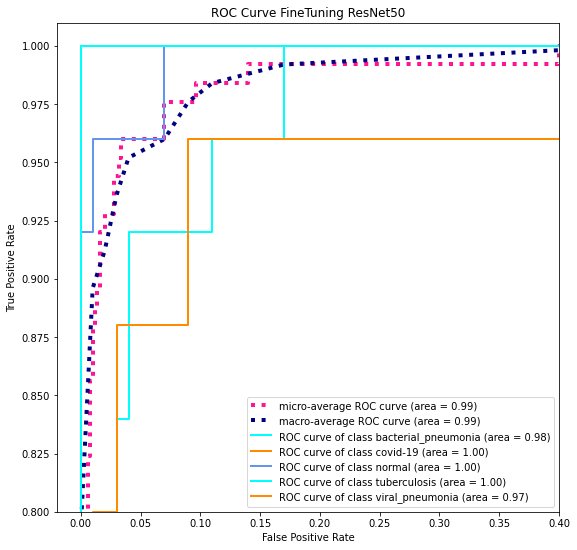

In [ ]:
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
print(predIdxs.shape)

plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning ResNet50')

# NO AUGMENTATION on data normalized to (0-1)

**WITHOUT DATA AUGMENTATION TRAINING**

In [ ]:
del model
model = build_ImageNetModel(ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss',factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('ResNet50 normalized set.h5', verbose=1,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Fits the model on batches
hist = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val, Y_val))


Epoch 1/100
15/15 [==============================] - 7s 234ms/step - loss: 2.0399 - accuracy: 0.2506 - val_loss: 1.6758 - val_accuracy: 0.2080

Epoch 00001: val_loss improved from inf to 1.67583, saving model to ResNet50 normalized set.h5
Epoch 2/100
15/15 [==============================] - 2s 133ms/step - loss: 1.7154 - accuracy: 0.3299 - val_loss: 1.7726 - val_accuracy: 0.3360

Epoch 00002: val_loss did not improve from 1.67583
Epoch 3/100
15/15 [==============================] - 2s 129ms/step - loss: 1.4584 - accuracy: 0.4403 - val_loss: 1.7820 - val_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.67583
Epoch 4/100
15/15 [==============================] - 2s 128ms/step - loss: 1.3210 - accuracy: 0.4729 - val_loss: 1.6875 - val_accuracy: 0.2960

Epoch 00004: val_loss did not improve from 1.67583
Epoch 5/100
15/15 [==============================] - 2s 129ms/step - loss: 1.2716 - accuracy: 0.5064 - val_loss: 1.6359 - val_accuracy: 0.3760

Epoch 00005: val_loss improved f

4/4 [==============================] - 10s 2s/step - loss: 0.3739 - accuracy: 0.8960
Final Loss: 0.3739401698112488, Final Accuracy: 0.8960000276565552
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.81      0.88      0.85        25
           covid-19       1.00      0.96      0.98        25
             normal       0.86      0.96      0.91        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.85      0.68      0.76        25

           accuracy                           0.90       125
          macro avg       0.90      0.90      0.89       125
       weighted avg       0.90      0.90      0.89       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


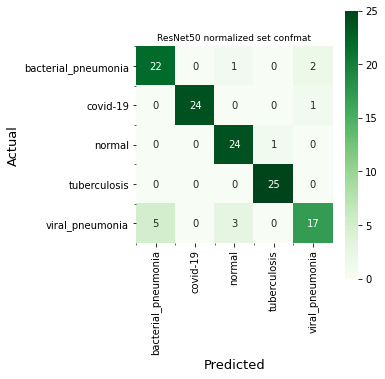

In [ ]:
# del model
model = load_model('ResNet50 normalized set.h5')

final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

plot_confusion_matrix('ResNet50 normalized set confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


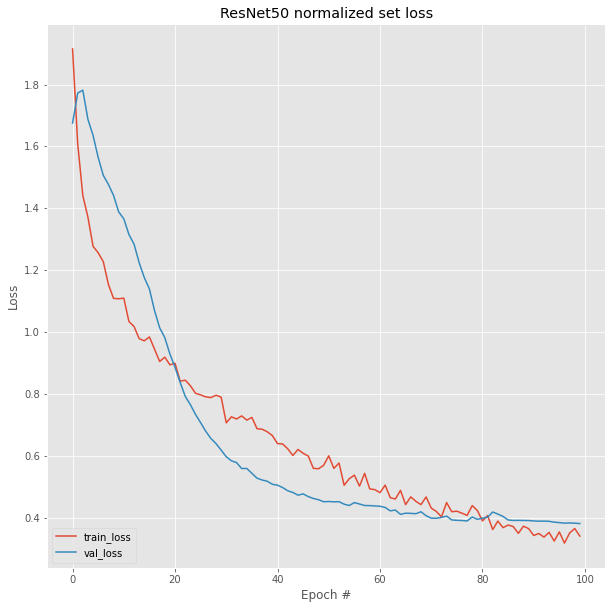

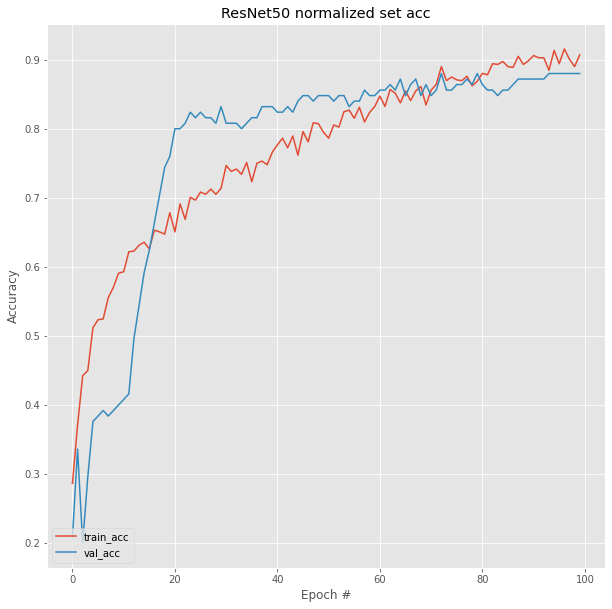

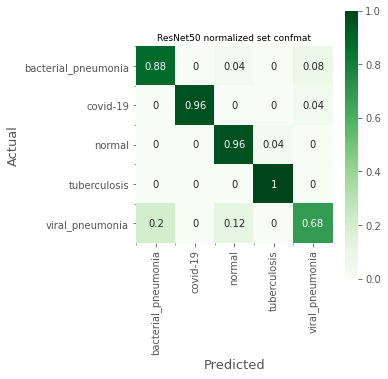

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'ResNet50 normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'ResNet50 normalized set acc')
plot_confusion_matrix('ResNet50 normalized set confmat',Y_true, predIdxs, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


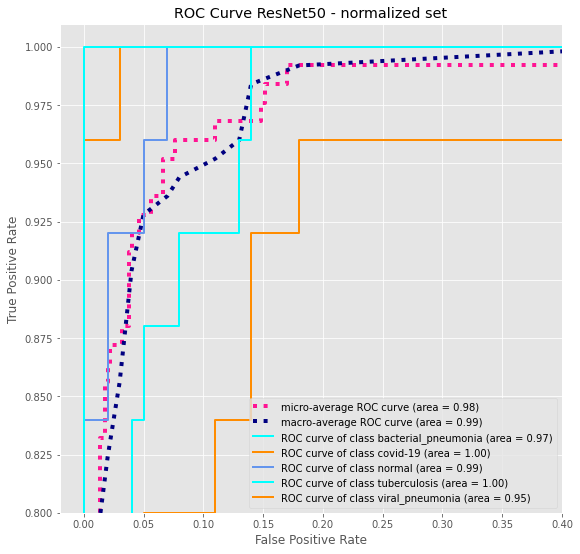

In [ ]:
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve ResNet50 - normalized set')

#FineTuning on normalized data

In [ ]:
model = load_model('ResNet50 normalized set.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[165:]:
    layer.trainable = True

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(new_lr)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned ResNet50 normalized set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_ft, Y_val_ft))

model
Epoch 1/100
37/37 [==============================] - 48s 321ms/step - loss: 1.0232 - accuracy: 0.6258 - val_loss: 1.8831 - val_accuracy: 0.4133

Epoch 00001: val_loss improved from inf to 1.88315, saving model to FineTuned ResNet50 normalized set.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 10s 255ms/step - loss: 0.8088 - accuracy: 0.7016 - val_loss: 2.8914 - val_accuracy: 0.3833

Epoch 00002: val_loss did not improve from 1.88315
Epoch 3/100
37/37 [==============================] - 10s 260ms/step - loss: 0.7446 - accuracy: 0.7466 - val_loss: 3.8905 - val_accuracy: 0.3367

Epoch 00003: val_loss did not improve from 1.88315
Epoch 4/100
37/37 [==============================] - 9s 255ms/step - loss: 0.6835 - accuracy: 0.7620 - val_loss: 6.6906 - val_accuracy: 0.2933

Epoch 00004: val_loss did not improve from 1.88315
Epoch 5/100
37/37 [==============================] - 9s 247ms/step - loss: 0.6647 - accuracy: 0.7637 - val_loss: 8.0740 - val_accuracy: 0.3633

Epoch 00005: val_loss did not improve from 1.88315
Epoch 6/100
37/37 [==============================] - 9s 243ms/step - loss: 0.6232 - accuracy: 0.7774 - val_loss: 7.7548 - val_accuracy: 0.3667

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951501

In [ ]:
del model
model = load_model('FineTuned ResNet50 normalized set.h5')
final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

# predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")
Y_pred = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 31s 636ms/step - loss: 0.2839 - accuracy: 0.9040
Final Loss: 0.2839467525482178, Final Accuracy: 0.9039999842643738
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.79      0.88      0.83        25
           covid-19       0.96      0.92      0.94        25
             normal       0.89      0.96      0.92        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.90      0.76      0.83        25

           accuracy                           0.90       125
          macro avg       0.91      0.90      0.90       125
       weighted avg       0.91      0.90      0.90       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


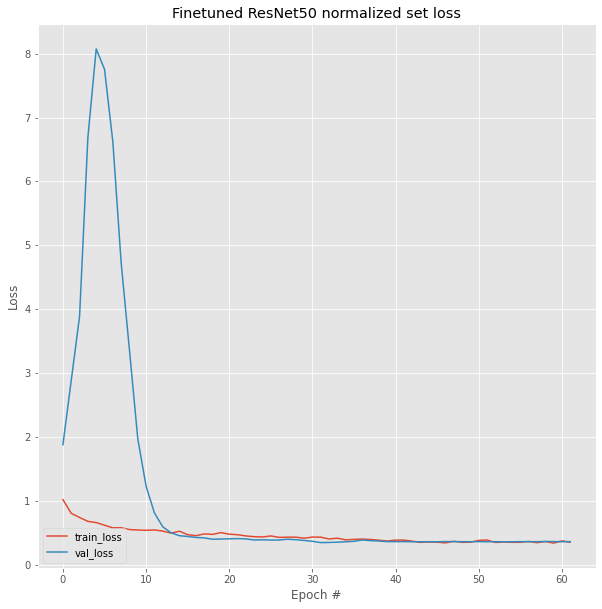

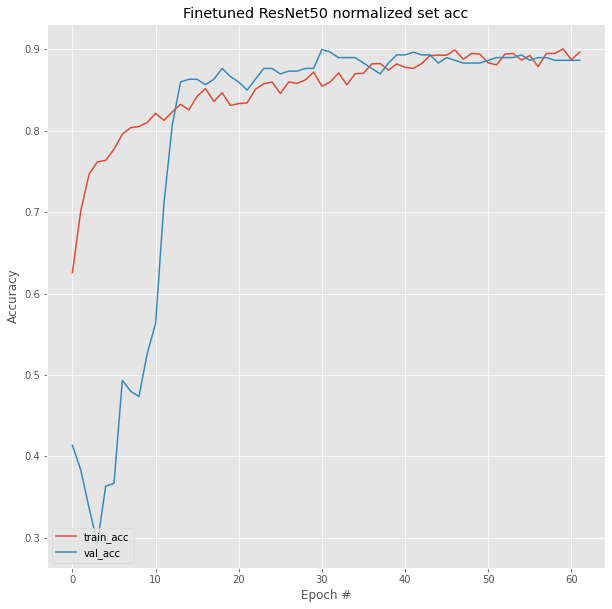

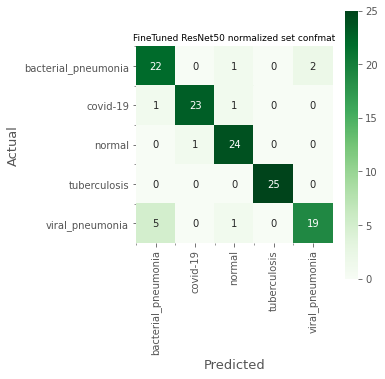

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned ResNet50 normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned ResNet50 normalized set acc')
plot_confusion_matrix('FineTuned ResNet50 normalized set confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


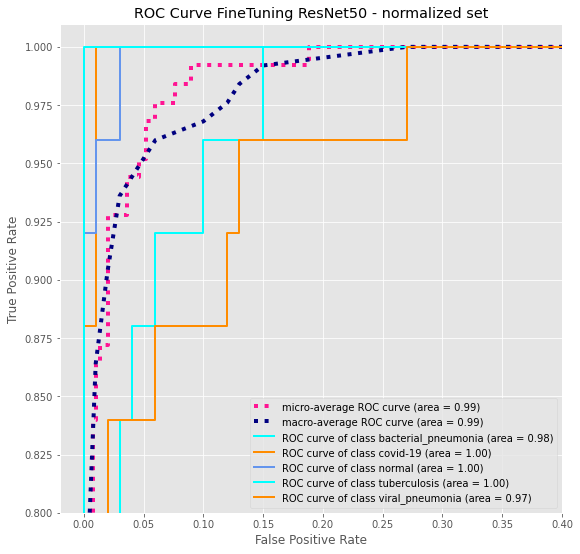

In [ ]:
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning ResNet50 - normalized set')

# NO AUGMENTATION on data divided by 255 + CLAHE processed

**After CLAHE processing without data augmentation**

In [ ]:
del model
model = build_ImageNetModel(ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('ResNet50 CLAHE set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Fits the model on batches
hist = model.fit(X_train_255_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE, Y_val))


Epoch 1/100
15/15 [==============================] - 6s 198ms/step - loss: 1.8709 - accuracy: 0.2928 - val_loss: 2.1361 - val_accuracy: 0.2160

Epoch 00001: val_loss improved from inf to 2.13615, saving model to ResNet50 CLAHE set.h5
Epoch 2/100
15/15 [==============================] - 2s 133ms/step - loss: 1.6094 - accuracy: 0.3641 - val_loss: 2.2808 - val_accuracy: 0.2720

Epoch 00002: val_loss did not improve from 2.13615
Epoch 3/100
15/15 [==============================] - 2s 130ms/step - loss: 1.4237 - accuracy: 0.4026 - val_loss: 2.1474 - val_accuracy: 0.3600

Epoch 00003: val_loss did not improve from 2.13615
Epoch 4/100
15/15 [==============================] - 2s 129ms/step - loss: 1.3324 - accuracy: 0.4821 - val_loss: 1.8337 - val_accuracy: 0.3440

Epoch 00004: val_loss improved from 2.13615 to 1.83365, saving model to ResNet50 CLAHE set.h5
Epoch 5/100
15/15 [==============================] - 2s 130ms/step - loss: 1.2767 - accuracy: 0.4806 - val_loss: 1.6751 - val_accuracy: 0.

4/4 [==============================] - 9s 2s/step - loss: 0.4217 - accuracy: 0.8640
Final Loss: 0.4217146337032318, Final Accuracy: 0.8640000224113464
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.80      0.80        25
           covid-19       0.93      1.00      0.96        25
             normal       0.80      0.96      0.87        25
       tuberculosis       0.96      0.96      0.96        25
    viral_pneumonia       0.83      0.60      0.70        25

           accuracy                           0.86       125
          macro avg       0.86      0.86      0.86       125
       weighted avg       0.86      0.86      0.86       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


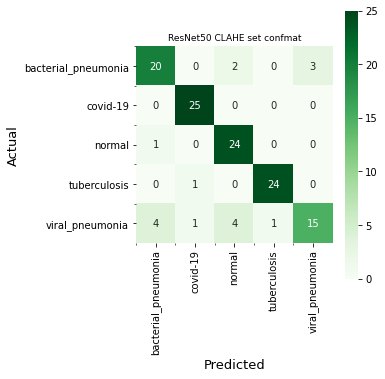

In [ ]:
del model
model = load_model('ResNet50 CLAHE set.h5')

final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

plot_confusion_matrix('ResNet50 CLAHE set confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


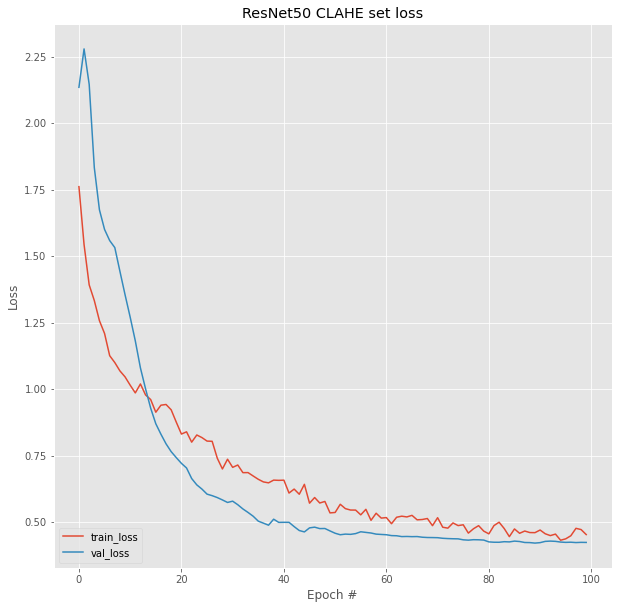

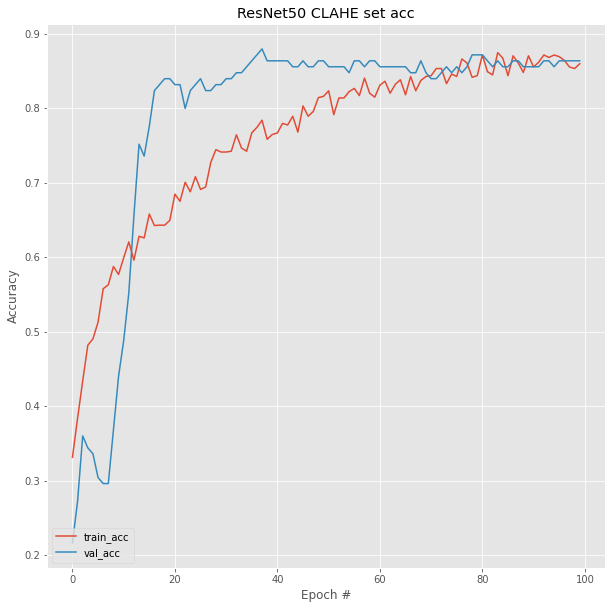

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'ResNet50 CLAHE set loss')
plot_acc(hist, hist.epoch[-1]+1, 'ResNet50 CLAHE set acc')
plot_confusion_matrix('ResNet50 CLAHE set confmat',Y_true, predIdxs, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


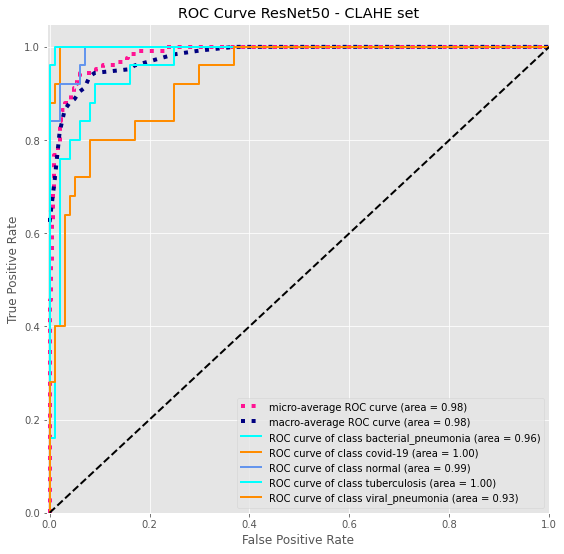

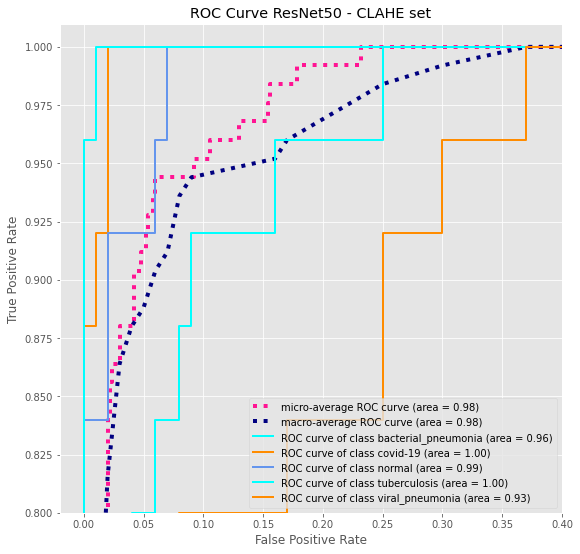

In [ ]:
predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve ResNet50 - CLAHE set')

#FineTuning on CLAHE and /255

In [ ]:
model = load_model('ResNet50 CLAHE set.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:165]:
    layer.trainable = False

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

print(optimizer.learning_rate)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned ResNet50 CLAHE set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train_255_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE_ft, Y_val_ft))

model
Epoch 1/100
37/37 [==============================] - 46s 286ms/step - loss: 1.0801 - accuracy: 0.5938 - val_loss: 1.2239 - val_accuracy: 0.5867

Epoch 00001: val_loss improved from inf to 1.22389, saving model to FineTuned ResNet50 CLAHE set.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 10s 233ms/step - loss: 0.8685 - accuracy: 0.6785 - val_loss: 1.8875 - val_accuracy: 0.3067

Epoch 00002: val_loss did not improve from 1.22389
Epoch 3/100
37/37 [==============================] - 9s 232ms/step - loss: 0.8096 - accuracy: 0.7016 - val_loss: 2.9901 - val_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.22389
Epoch 4/100
37/37 [==============================] - 8s 229ms/step - loss: 0.7741 - accuracy: 0.7205 - val_loss: 2.6056 - val_accuracy: 0.2467

Epoch 00004: val_loss did not improve from 1.22389
Epoch 5/100
37/37 [==============================] - 8s 230ms/step - loss: 0.7107 - accuracy: 0.7423 - val_loss: 2.3810 - val_accuracy: 0.2867

Epoch 00005: val_loss did not improve from 1.22389
Epoch 6/100
37/37 [==============================] - 9s 231ms/step - loss: 0.6946 - accuracy: 0.7470 - val_loss: 2.2819 - val_accuracy: 0.3433

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951501e

In [ ]:
del model
model = load_model('FineTuned ResNet50 CLAHE set.h5')
final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")
Y_pred = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 2s 220ms/step - loss: 0.3371 - accuracy: 0.8880
Final Loss: 0.3370741009712219, Final Accuracy: 0.8880000114440918
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.72      0.84      0.78        25
           covid-19       0.96      1.00      0.98        25
             normal       0.89      1.00      0.94        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.88      0.60      0.71        25

           accuracy                           0.89       125
          macro avg       0.89      0.89      0.88       125
       weighted avg       0.89      0.89      0.88       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


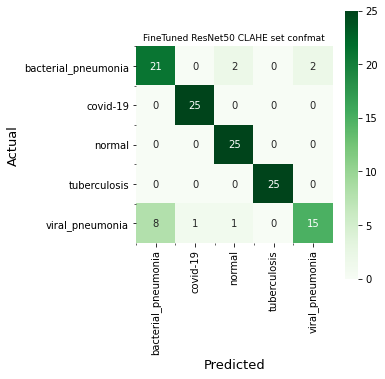

In [ ]:
plot_confusion_matrix('FineTuned ResNet50 CLAHE set confmat',Y_true, Y_pred, categories)

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


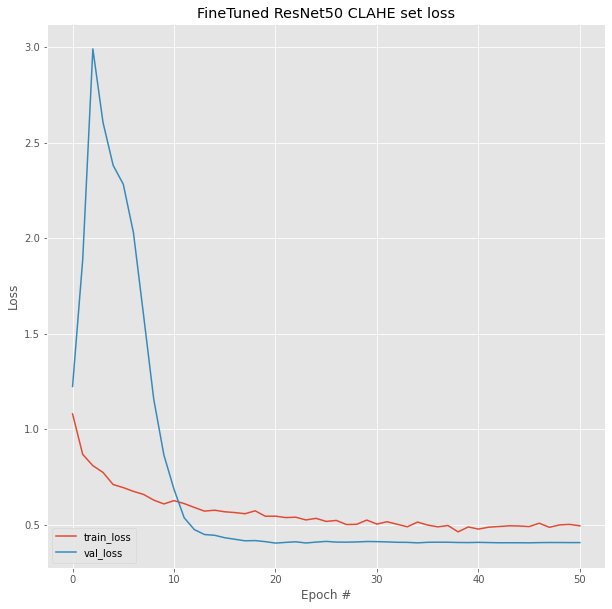

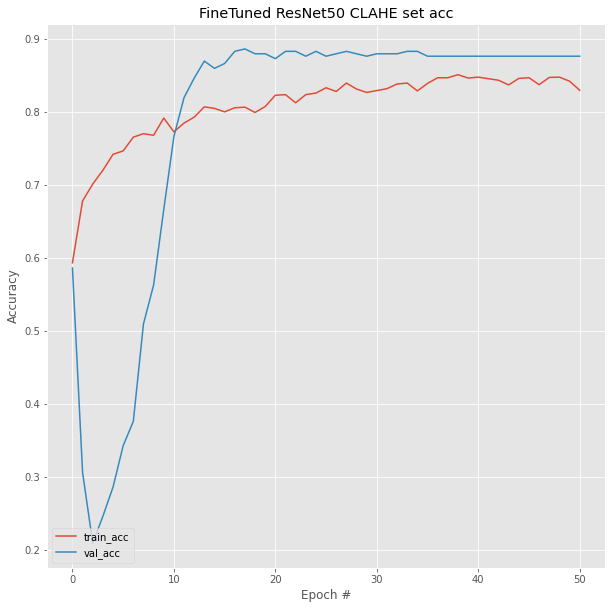

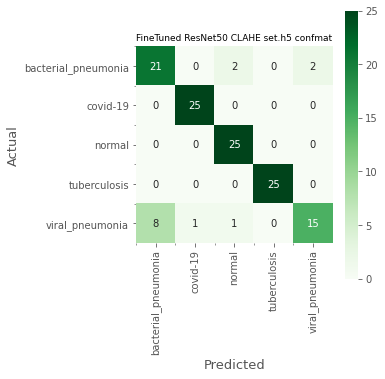

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'FineTuned ResNet50 CLAHE set loss')
plot_acc(hist, hist.epoch[-1]+1, 'FineTuned ResNet50 CLAHE set acc')
plot_confusion_matrix('FineTuned ResNet50 CLAHE set confmat.h5',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


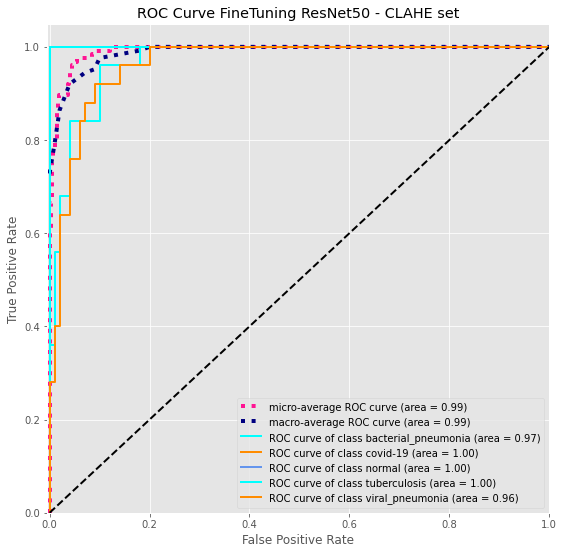

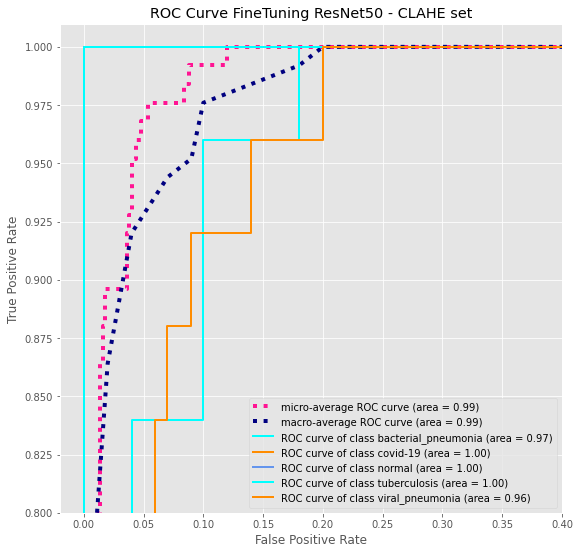

In [ ]:
predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning ResNet50 - CLAHE set')

# NO AUGMENTATION on data normalized to (0-1) + CLAHE processed

**After CLAHE processing without data augmentation**

In [ ]:
del model
model = build_ImageNetModel(ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('ResNet50 CLAHE + normalized set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Fits the model on batches
hist = model.fit(X_train_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE, Y_val))


Epoch 1/100
15/15 [==============================] - 7s 203ms/step - loss: 2.0635 - accuracy: 0.2341 - val_loss: 1.6345 - val_accuracy: 0.2560

Epoch 00001: val_loss improved from inf to 1.63446, saving model to ResNet50 CLAHE + normalized set.h5
Epoch 2/100
15/15 [==============================] - 2s 133ms/step - loss: 1.5922 - accuracy: 0.3787 - val_loss: 1.8008 - val_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.63446
Epoch 3/100
15/15 [==============================] - 2s 129ms/step - loss: 1.5196 - accuracy: 0.3875 - val_loss: 1.7655 - val_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.63446
Epoch 4/100
15/15 [==============================] - 2s 128ms/step - loss: 1.3331 - accuracy: 0.4504 - val_loss: 1.7177 - val_accuracy: 0.2240

Epoch 00004: val_loss did not improve from 1.63446
Epoch 5/100
15/15 [==============================] - 2s 130ms/step - loss: 1.3642 - accuracy: 0.4671 - val_loss: 1.6767 - val_accuracy: 0.3120

Epoch 00005: val_loss di

4/4 [==============================] - 9s 2s/step - loss: 0.4512 - accuracy: 0.8800
Final Loss: 0.4512284994125366, Final Accuracy: 0.8799999952316284
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.78      0.84      0.81        25
           covid-19       1.00      0.88      0.94        25
             normal       0.86      1.00      0.93        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.81      0.68      0.74        25

           accuracy                           0.88       125
          macro avg       0.88      0.88      0.88       125
       weighted avg       0.88      0.88      0.88       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


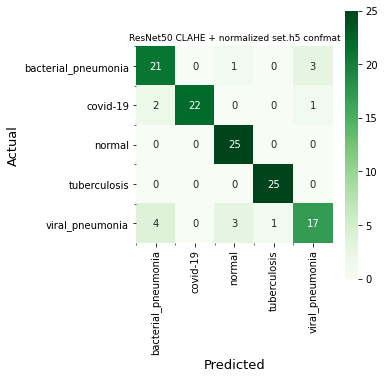

In [ ]:
del model
model = load_model('ResNet50 CLAHE + normalized set.h5')

final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))


#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

plot_confusion_matrix('ResNet50 CLAHE + normalized set.h5 confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


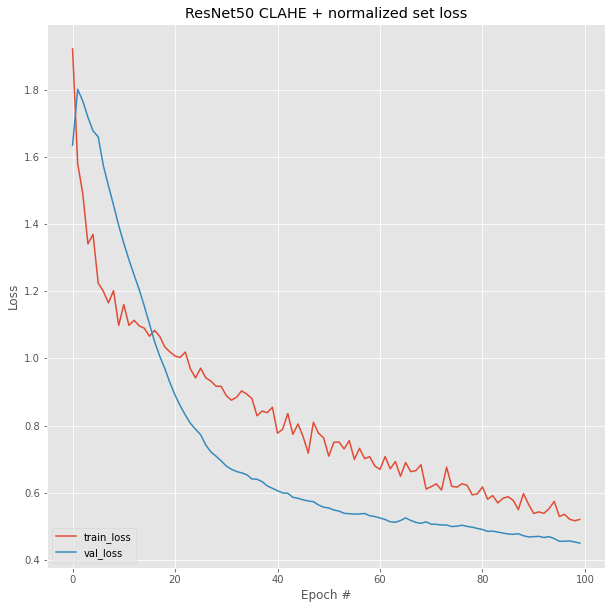

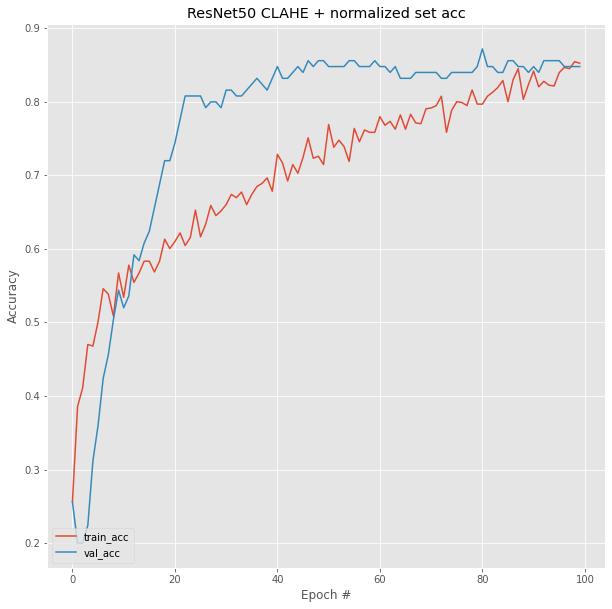

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'ResNet50 CLAHE + normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'ResNet50 CLAHE + normalized set acc')
plot_confusion_matrix('ResNet50 CLAHE + normalized set.h5 confmat',Y_true, predIdxs, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


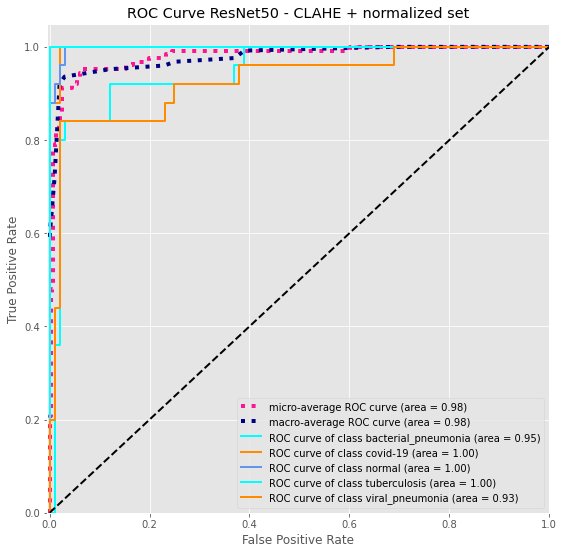

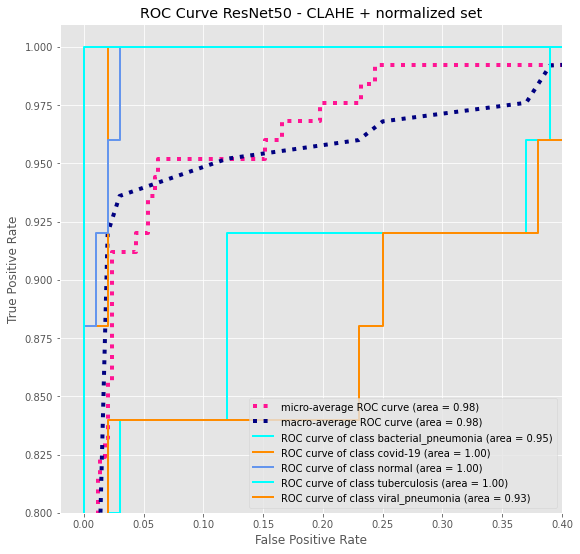

In [ ]:
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve ResNet50 - CLAHE + normalized set')

#FineTuning on CLAHE + normalized data

In [ ]:
del model
model = load_model('ResNet50 CLAHE + normalized set.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[165:]:
    layer.trainable = True


optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

print(optimizer.learning_rate)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned ResNet50 CLAHE + normalized set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE_ft, Y_val_ft))

model
Epoch 1/100
37/37 [==============================] - 14s 272ms/step - loss: 1.1921 - accuracy: 0.5338 - val_loss: 0.8070 - val_accuracy: 0.7933

Epoch 00001: val_loss improved from inf to 0.80701, saving model to FineTuned ResNet50 CLAHE + normalized set.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 9s 249ms/step - loss: 0.9338 - accuracy: 0.6481 - val_loss: 1.3207 - val_accuracy: 0.4133

Epoch 00002: val_loss did not improve from 0.80701
Epoch 3/100
37/37 [==============================] - 9s 252ms/step - loss: 0.8919 - accuracy: 0.6717 - val_loss: 1.9306 - val_accuracy: 0.3567

Epoch 00003: val_loss did not improve from 0.80701
Epoch 4/100
37/37 [==============================] - 9s 247ms/step - loss: 0.8177 - accuracy: 0.6986 - val_loss: 3.9765 - val_accuracy: 0.2200

Epoch 00004: val_loss did not improve from 0.80701
Epoch 5/100
37/37 [==============================] - 9s 241ms/step - loss: 0.7870 - accuracy: 0.7166 - val_loss: 5.7458 - val_accuracy: 0.2033

Epoch 00005: val_loss did not improve from 0.80701
Epoch 6/100
37/37 [==============================] - 9s 240ms/step - loss: 0.7616 - accuracy: 0.7282 - val_loss: 6.3715 - val_accuracy: 0.2033

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-

In [ ]:
del model
model = load_model('FineTuned ResNet50 CLAHE + normalized set.h5')
final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))


#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")
Y_pred = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 2s 219ms/step - loss: 0.3573 - accuracy: 0.9040
Final Loss: 0.3572792410850525, Final Accuracy: 0.9039999842643738
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.74      0.92      0.82        25
           covid-19       1.00      0.88      0.94        25
             normal       0.96      1.00      0.98        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.86      0.72      0.78        25

           accuracy                           0.90       125
          macro avg       0.91      0.90      0.90       125
       weighted avg       0.91      0.90      0.90       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


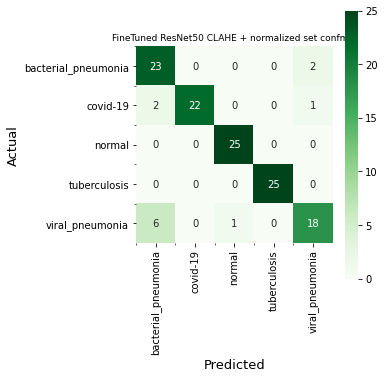

In [ ]:
plot_confusion_matrix('FineTuned ResNet50 CLAHE + normalized set confmat',Y_true, Y_pred, categories)

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


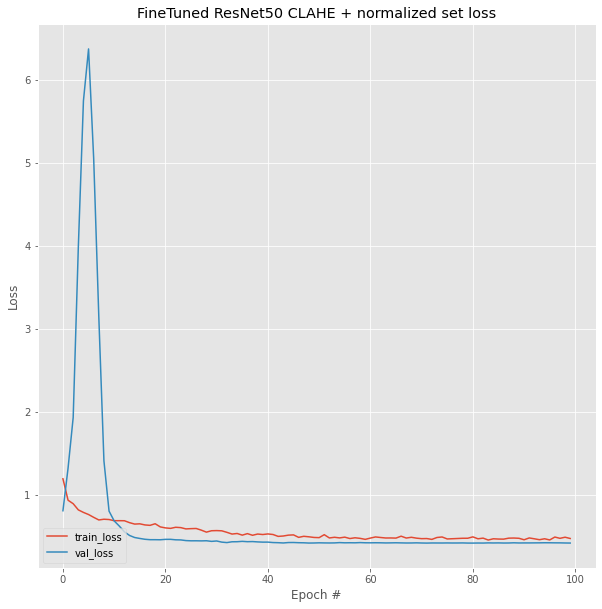

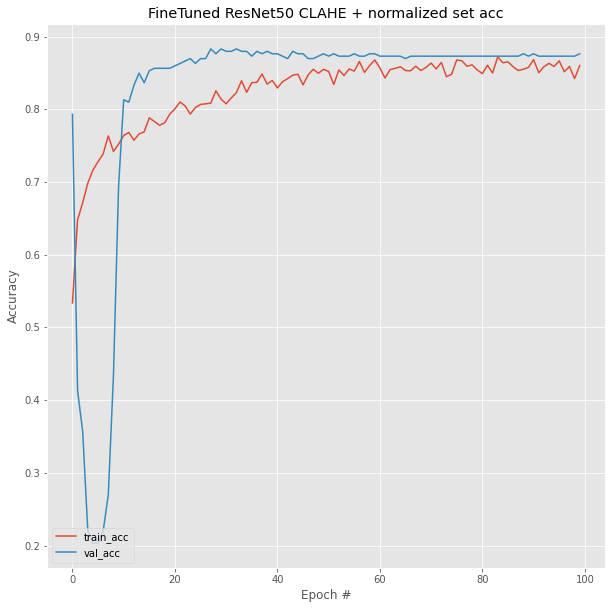

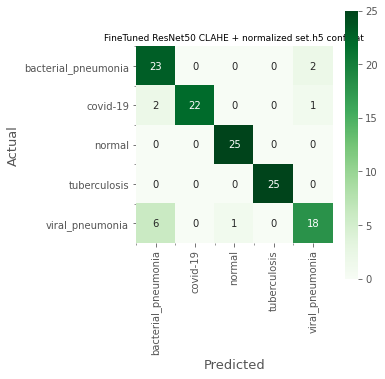

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'FineTuned ResNet50 CLAHE + normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'FineTuned ResNet50 CLAHE + normalized set acc')
plot_confusion_matrix('FineTuned ResNet50 CLAHE + normalized set.h5 confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


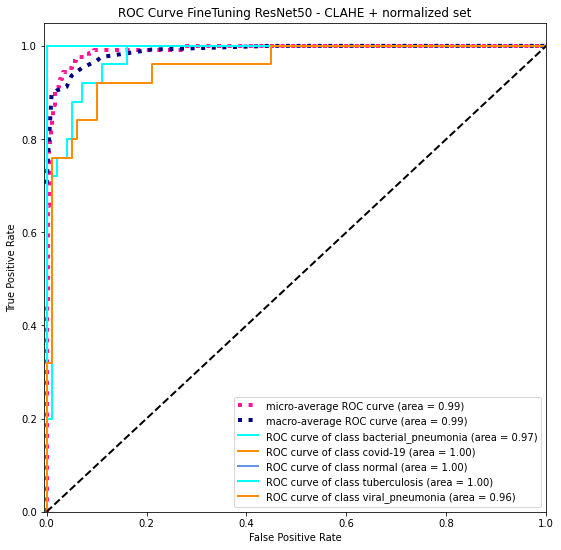

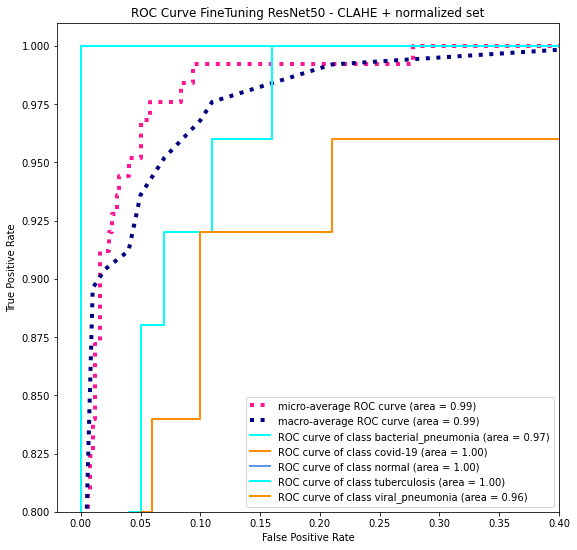

In [ ]:
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning ResNet50 - CLAHE + normalized set')

# AUGMENTATION on data divided by 255

In [ ]:
del model
model = build_ImageNetModel(ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('ResNet50 Augmentation on data divided by 255.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             fill_mode = "nearest")  

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_255, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255, Y_val))


Epoch 1/100
15/15 [==============================] - 13s 632ms/step - loss: 2.1135 - accuracy: 0.2114 - val_loss: 1.7842 - val_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.78420, saving model to ResNet50 Augmentation on data divided by 255.h5
Epoch 2/100
15/15 [==============================] - 8s 547ms/step - loss: 1.7713 - accuracy: 0.3380 - val_loss: 1.7870 - val_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.78420
Epoch 3/100
15/15 [==============================] - 9s 620ms/step - loss: 1.6418 - accuracy: 0.3768 - val_loss: 1.7276 - val_accuracy: 0.2000

Epoch 00003: val_loss improved from 1.78420 to 1.72760, saving model to ResNet50 Augmentation on data divided by 255.h5
Epoch 4/100
15/15 [==============================] - 8s 551ms/step - loss: 1.4718 - accuracy: 0.4233 - val_loss: 1.6671 - val_accuracy: 0.2000

Epoch 00004: val_loss improved from 1.72760 to 1.66711, saving model to ResNet50 Augmentation on data divided by 255.h5
Epoch 5/100
15/1

4/4 [==============================] - 9s 2s/step - loss: 0.4499 - accuracy: 0.8240
Final Loss: 0.44989579916000366, Final Accuracy: 0.8240000009536743
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.64      0.71        25
           covid-19       0.92      0.96      0.94        25
             normal       0.73      0.96      0.83        25
       tuberculosis       0.92      0.96      0.94        25
    viral_pneumonia       0.75      0.60      0.67        25

           accuracy                           0.82       125
          macro avg       0.82      0.82      0.82       125
       weighted avg       0.82      0.82      0.82       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


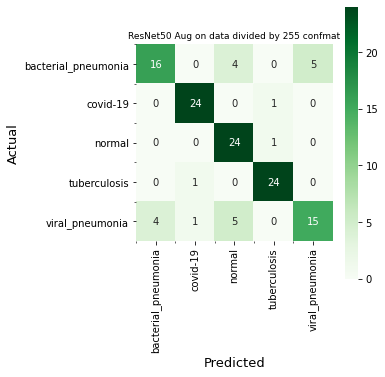

In [ ]:
del model
model = load_model('ResNet50 Augmentation on data divided by 255.h5')

final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

plot_confusion_matrix('ResNet50 Aug on data divided by 255 confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


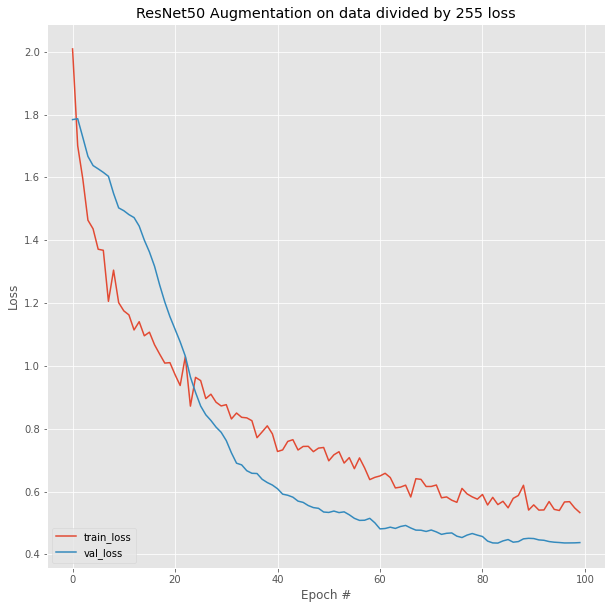

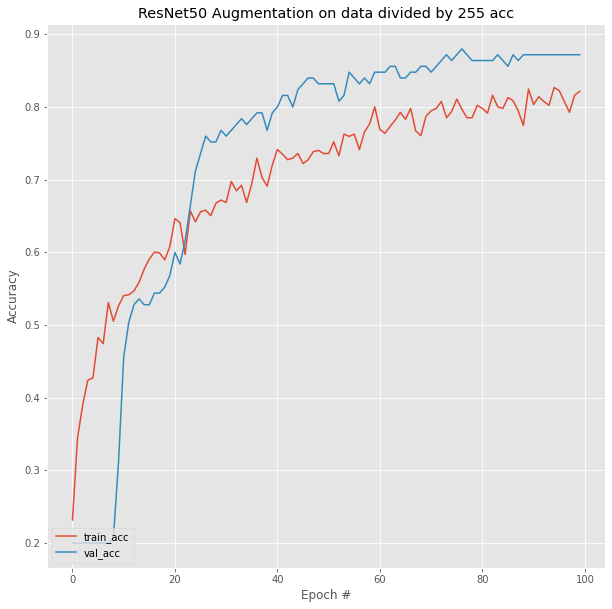

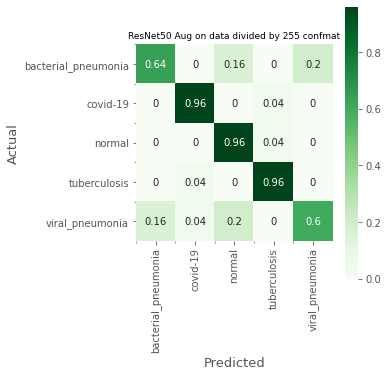

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'ResNet50 Augmentation on data divided by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'ResNet50 Augmentation on data divided by 255 acc')
plot_confusion_matrix('ResNet50 Aug on data divided by 255 confmat',Y_true, predIdxs, categories)

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


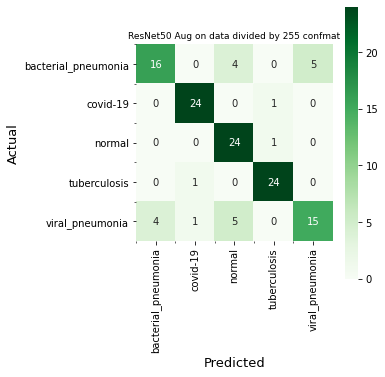

In [ ]:
plot_confusion_matrix('ResNet50 Aug on data divided by 255 confmat',Y_true, predIdxs, categories, False)

(125, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


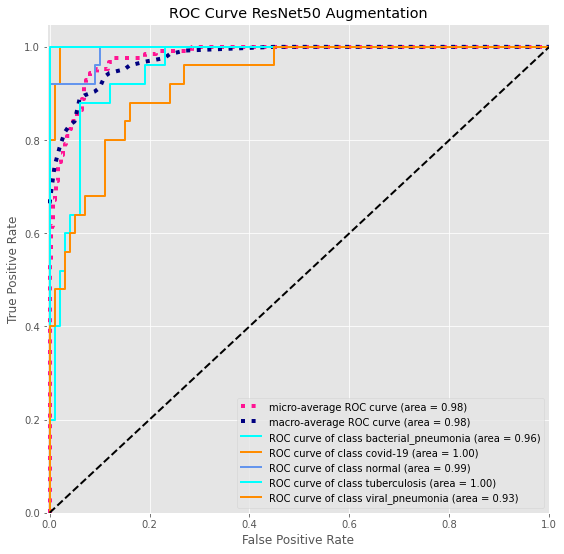

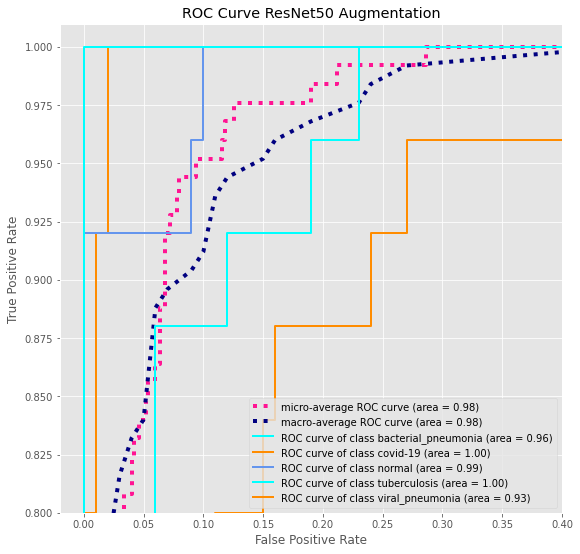

In [ ]:
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
print(predIdxs.shape)

plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve ResNet50 Augmentation')

#FineTuning

In [ ]:
del model
model = load_model('ResNet50 Augmentation on data divided by 255.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:165]:
    layer.trainable = False

optimizer = Adam(lr=new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(new_lr)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned ResNet50 Augmentation on data divided by 255.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             fill_mode = "nearest"
)

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_255_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_ft, Y_val_ft))



model
Epoch 1/100
37/37 [==============================] - 28s 648ms/step - loss: 1.0832 - accuracy: 0.6049 - val_loss: 1.3567 - val_accuracy: 0.3567

Epoch 00001: val_loss improved from inf to 1.35667, saving model to FineTuned ResNet50 Augmentation on data divided by 255.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 23s 625ms/step - loss: 0.8832 - accuracy: 0.6764 - val_loss: 4.6977 - val_accuracy: 0.2067

Epoch 00002: val_loss did not improve from 1.35667
Epoch 3/100
37/37 [==============================] - 22s 601ms/step - loss: 0.8217 - accuracy: 0.7016 - val_loss: 13.2381 - val_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.35667
Epoch 4/100
37/37 [==============================] - 23s 606ms/step - loss: 0.8023 - accuracy: 0.7063 - val_loss: 15.0513 - val_accuracy: 0.2000

Epoch 00004: val_loss did not improve from 1.35667
Epoch 5/100
37/37 [==============================] - 22s 600ms/step - loss: 0.7769 - accuracy: 0.7123 - val_loss: 13.8988 - val_accuracy: 0.2000

Epoch 00005: val_loss did not improve from 1.35667
Epoch 6/100
37/37 [==============================] - 22s 600ms/step - loss: 0.7605 - accuracy: 0.7192 - val_loss: 10.1977 - val_accuracy: 0.2000

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.99999989

In [ ]:
del model
model = load_model('FineTuned ResNet50 Augmentation on data divided by 255.h5')

final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)

print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))


#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning network...")

Y_pred = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 1s 108ms/step - loss: 0.3669 - accuracy: 0.8640
Final Loss: 0.36686787009239197, Final Accuracy: 0.8640000224113464
[INFO] evaluating after fine tuning network...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.77      0.80      0.78        25
           covid-19       1.00      0.88      0.94        25
             normal       0.83      0.96      0.89        25
       tuberculosis       0.93      1.00      0.96        25
    viral_pneumonia       0.81      0.68      0.74        25

           accuracy                           0.86       125
          macro avg       0.87      0.86      0.86       125
       weighted avg       0.87      0.86      0.86       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


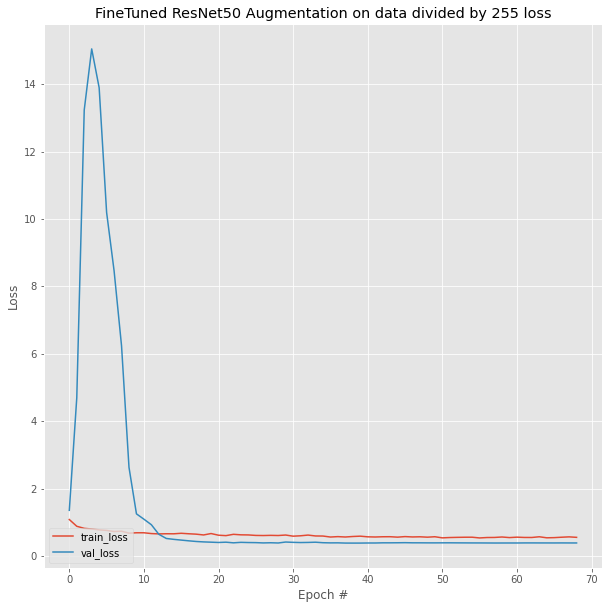

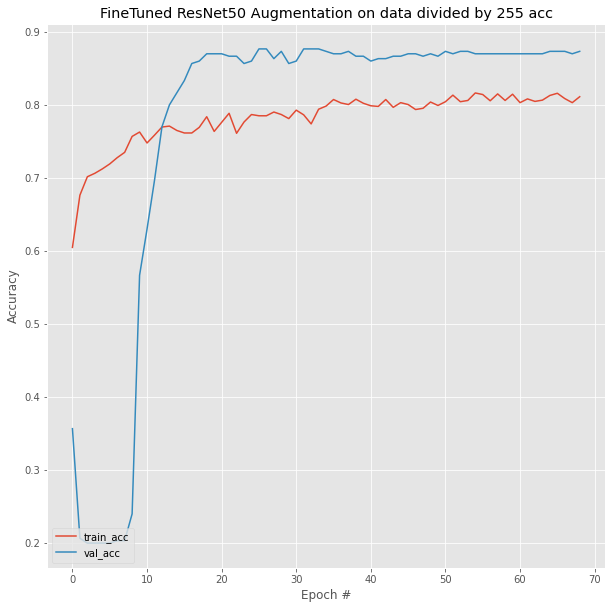

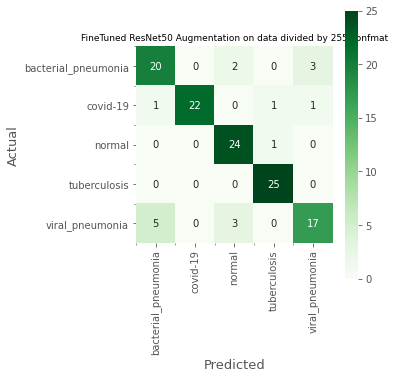

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'FineTuned ResNet50 Augmentation on data divided by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'FineTuned ResNet50 Augmentation on data divided by 255 acc')
plot_confusion_matrix('FineTuned ResNet50 Augmentation on data divided by 255 confmat', Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


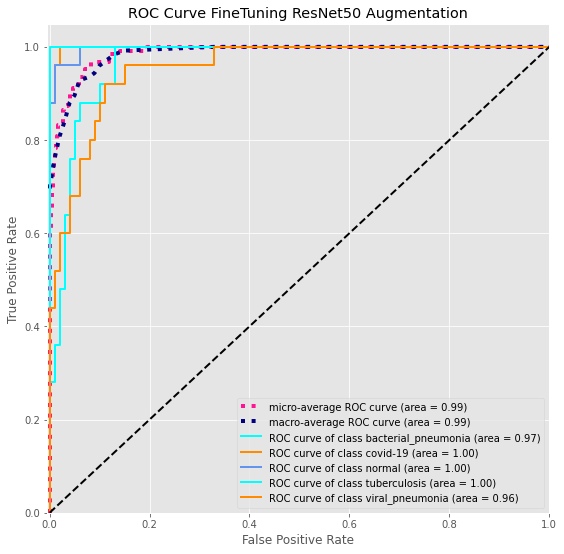

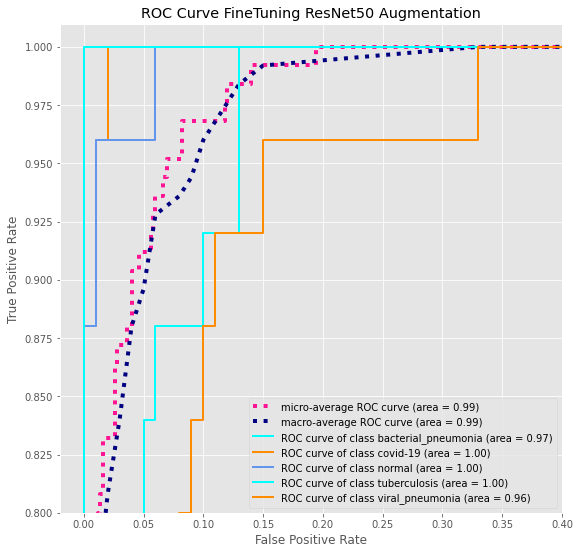

In [ ]:
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning ResNet50 Augmentation')

# AUGMENTATION on data normalized to (0-1)

**Transfer learning on ResNet50 before hist manipulation**

In [ ]:
del model
model = build_ImageNetModel(ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('ResNet50 Augmentation normalized.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             fill_mode='nearest'
                             )  

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val, Y_val))


Epoch 1/100
15/15 [==============================] - 13s 629ms/step - loss: 2.0541 - accuracy: 0.2592 - val_loss: 1.8189 - val_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.81890, saving model to ResNet50 Augmentation normalized.h5
Epoch 2/100
15/15 [==============================] - 8s 545ms/step - loss: 1.6339 - accuracy: 0.3857 - val_loss: 1.8349 - val_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.81890
Epoch 3/100
15/15 [==============================] - 9s 582ms/step - loss: 1.5320 - accuracy: 0.4083 - val_loss: 1.7982 - val_accuracy: 0.2000

Epoch 00003: val_loss improved from 1.81890 to 1.79817, saving model to ResNet50 Augmentation normalized.h5
Epoch 4/100
15/15 [==============================] - 8s 568ms/step - loss: 1.3913 - accuracy: 0.4320 - val_loss: 1.7287 - val_accuracy: 0.2480

Epoch 00004: val_loss improved from 1.79817 to 1.72869, saving model to ResNet50 Augmentation normalized.h5
Epoch 5/100
15/15 [==============================] -

4/4 [==============================] - 9s 2s/step - loss: 0.4457 - accuracy: 0.8240
Final Loss: 0.44568195939064026, Final Accuracy: 0.8240000009536743
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.82      0.72      0.77        25
           covid-19       0.92      0.92      0.92        25
             normal       0.77      0.92      0.84        25
       tuberculosis       0.89      0.96      0.92        25
    viral_pneumonia       0.71      0.60      0.65        25

           accuracy                           0.82       125
          macro avg       0.82      0.82      0.82       125
       weighted avg       0.82      0.82      0.82       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


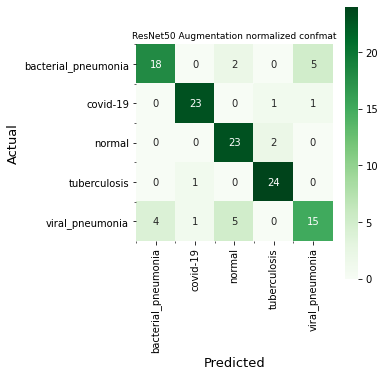

In [ ]:
del model
model = load_model('ResNet50 Augmentation normalized.h5')

final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))
plot_confusion_matrix('ResNet50 Augmentation normalized confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


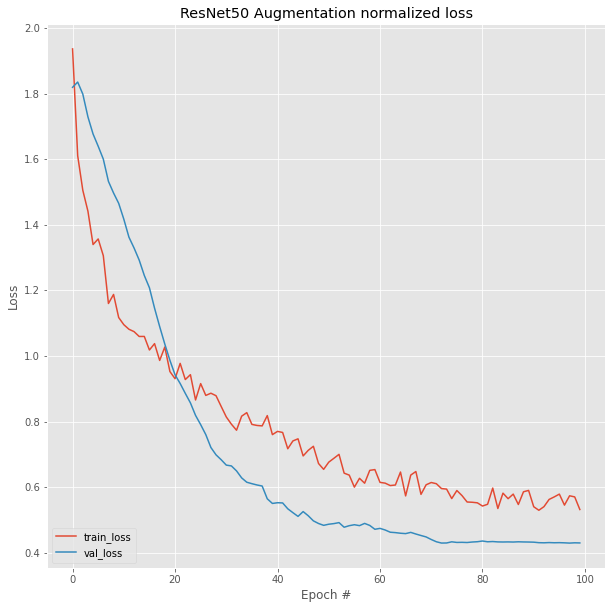

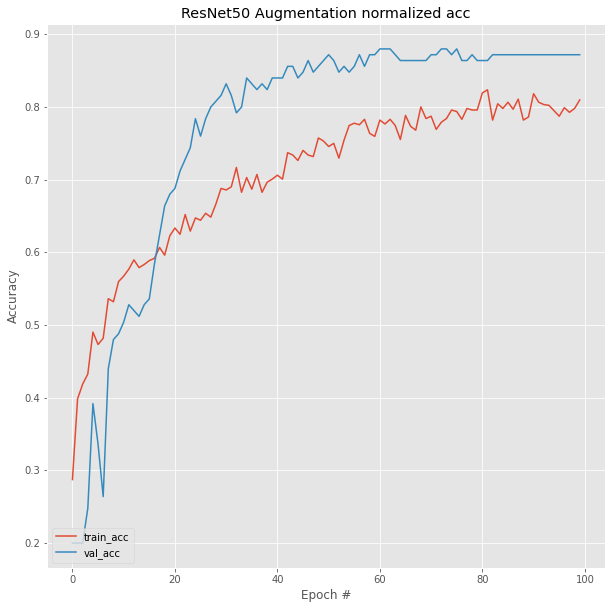

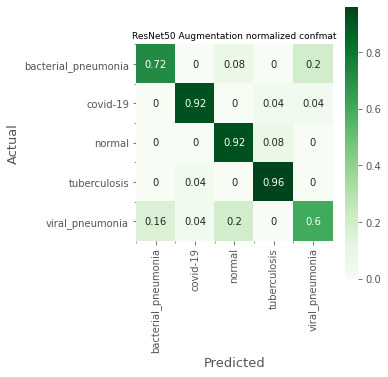

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'ResNet50 Augmentation normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'ResNet50 Augmentation normalized acc')
plot_confusion_matrix('ResNet50 Augmentation normalized confmat',Y_true, predIdxs, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


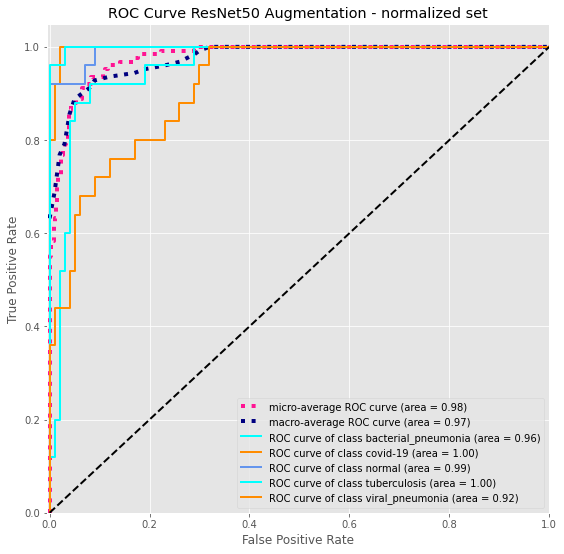

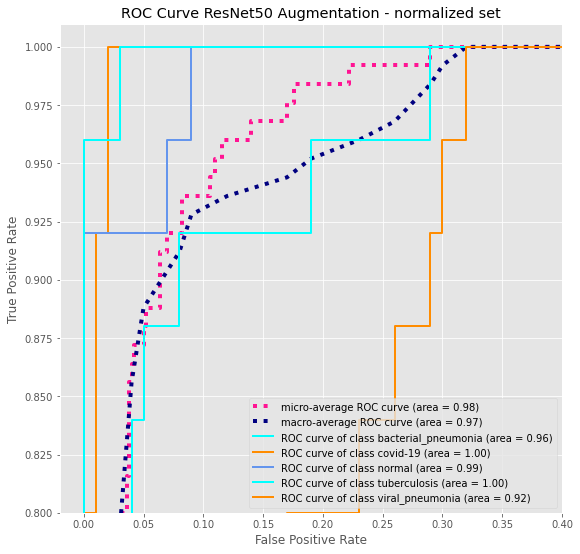

In [ ]:
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve ResNet50 Augmentation - normalized set')

#FineTuning

In [ ]:
del model
model = load_model('ResNet50 Augmentation normalized.h5')


**FineTuning ResNet50 after data normalization 0-1**

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:165]:
    layer.trainable = False


optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(new_lr)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned ResNet50 Augmentation normalized.h5', verbose=1
                             ,save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             )
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_ft, Y_val_ft))

model
Epoch 1/100
37/37 [==============================] - 27s 644ms/step - loss: 1.0633 - accuracy: 0.5818 - val_loss: 2.1773 - val_accuracy: 0.3067

Epoch 00001: val_loss improved from inf to 2.17731, saving model to FineTuned ResNet50 Augmentation normalized.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 23s 627ms/step - loss: 0.8926 - accuracy: 0.6515 - val_loss: 6.1628 - val_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 2.17731
Epoch 3/100
37/37 [==============================] - 22s 602ms/step - loss: 0.8371 - accuracy: 0.6682 - val_loss: 9.8970 - val_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 2.17731
Epoch 4/100
37/37 [==============================] - 23s 614ms/step - loss: 0.7988 - accuracy: 0.6909 - val_loss: 12.8264 - val_accuracy: 0.2000

Epoch 00004: val_loss did not improve from 2.17731
Epoch 5/100
37/37 [==============================] - 22s 600ms/step - loss: 0.7844 - accuracy: 0.6884 - val_loss: 11.9553 - val_accuracy: 0.2000

Epoch 00005: val_loss did not improve from 2.17731
Epoch 6/100
37/37 [==============================] - 22s 602ms/step - loss: 0.7657 - accuracy: 0.7115 - val_loss: 11.6558 - val_accuracy: 0.1967

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898

In [ ]:
del model
model = load_model('FineTuned ResNet50 Augmentation normalized.h5')

final_loss, final_accuracy = model.evaluate(X_test, Y_test)

print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))


#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")

Y_pred = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 2s 213ms/step - loss: 0.3855 - accuracy: 0.8560
Final Loss: 0.3855314254760742, Final Accuracy: 0.8560000061988831
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.76      0.76      0.76        25
           covid-19       0.96      0.92      0.94        25
             normal       0.81      1.00      0.89        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.75      0.60      0.67        25

           accuracy                           0.86       125
          macro avg       0.85      0.86      0.85       125
       weighted avg       0.85      0.86      0.85       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


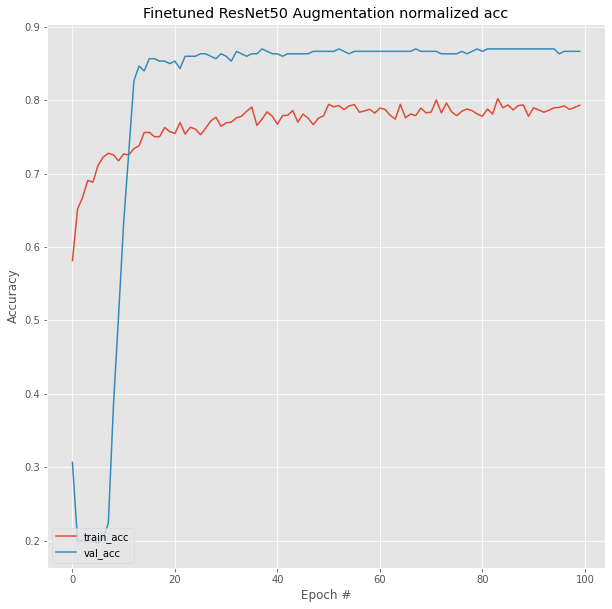

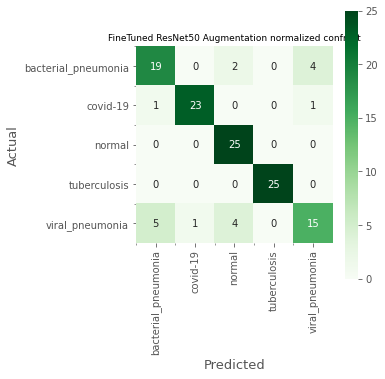

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned ResNet50 Augmentation normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned ResNet50 Augmentation normalized acc')
plot_confusion_matrix('FineTuned ResNet50 Augmentation normalized confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


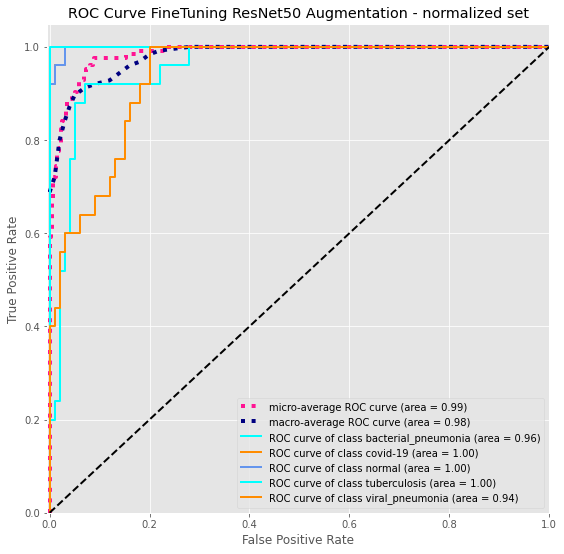

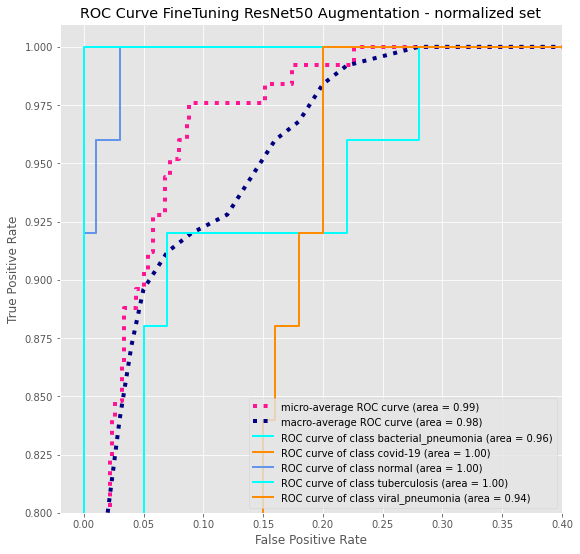

In [ ]:
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning ResNet50 Augmentation - normalized set')

# AUGMENTATION on data divided by 255 + CLAHE processed

**Transfer learning after CLAHE processing imgs**

In [ ]:
del model
model = build_ImageNetModel(ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('ResNet50 Augmentation CLAHE.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally   
                             )  

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_255_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE, Y_val))


Epoch 1/100
15/15 [==============================] - 13s 641ms/step - loss: 1.9084 - accuracy: 0.2676 - val_loss: 2.0722 - val_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 2.07216, saving model to ResNet50 Augmentation CLAHE.h5
Epoch 2/100
15/15 [==============================] - 8s 555ms/step - loss: 1.6049 - accuracy: 0.3695 - val_loss: 2.0024 - val_accuracy: 0.2000

Epoch 00002: val_loss improved from 2.07216 to 2.00243, saving model to ResNet50 Augmentation CLAHE.h5
Epoch 3/100
15/15 [==============================] - 8s 556ms/step - loss: 1.5379 - accuracy: 0.3891 - val_loss: 1.9191 - val_accuracy: 0.3280

Epoch 00003: val_loss improved from 2.00243 to 1.91909, saving model to ResNet50 Augmentation CLAHE.h5
Epoch 4/100
15/15 [==============================] - 8s 556ms/step - loss: 1.3732 - accuracy: 0.4535 - val_loss: 1.7795 - val_accuracy: 0.3920

Epoch 00004: val_loss improved from 1.91909 to 1.77951, saving model to ResNet50 Augmentation CLAHE.h5
Epoch 5/100
15/

4/4 [==============================] - 9s 2s/step - loss: 0.3856 - accuracy: 0.8640
Final Loss: 0.3855668902397156, Final Accuracy: 0.8640000224113464
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.73      0.76      0.75        25
           covid-19       0.93      1.00      0.96        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      0.96      0.98        25
    viral_pneumonia       0.79      0.60      0.68        25

           accuracy                           0.86       125
          macro avg       0.86      0.86      0.86       125
       weighted avg       0.86      0.86      0.86       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


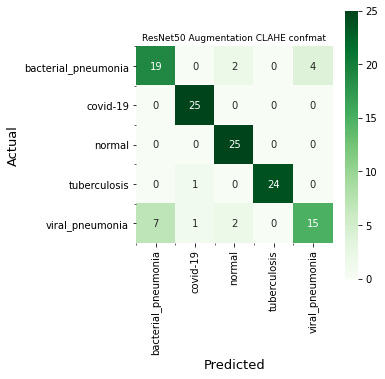

In [ ]:
del model
model = load_model('ResNet50 Augmentation CLAHE.h5')
final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))


#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

Y_pred = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

plot_confusion_matrix('ResNet50 Augmentation CLAHE confmat',Y_true, Y_pred, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


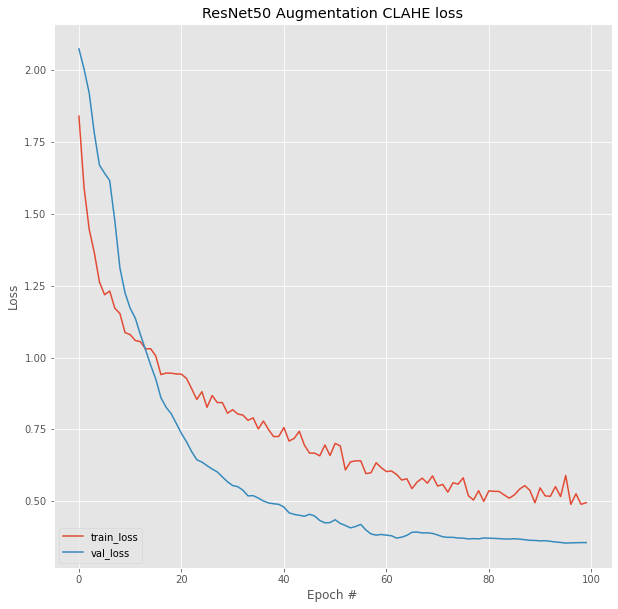

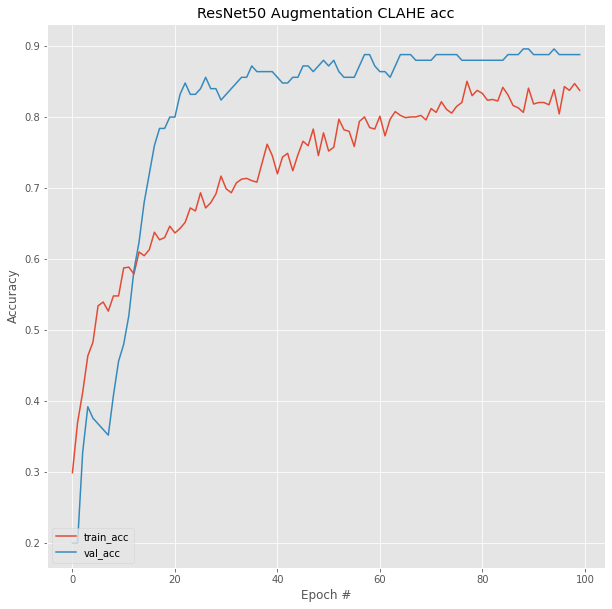

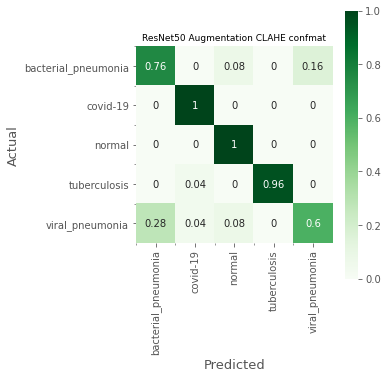

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'ResNet50 Augmentation CLAHE loss')
plot_acc(hist, hist.epoch[-1]+1, 'ResNet50 Augmentation CLAHE acc')
plot_confusion_matrix('ResNet50 Augmentation CLAHE confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


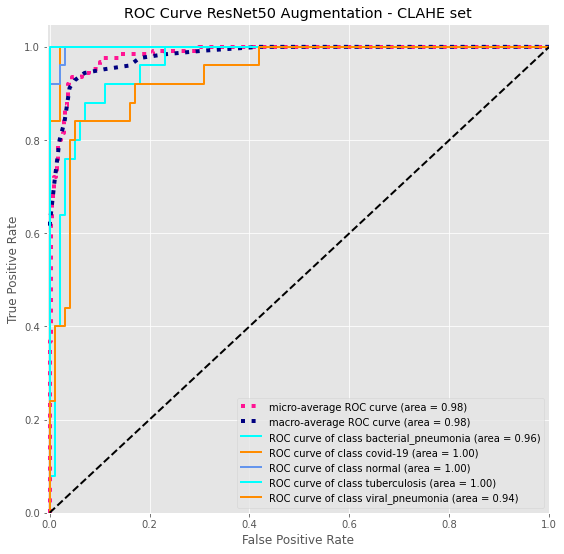

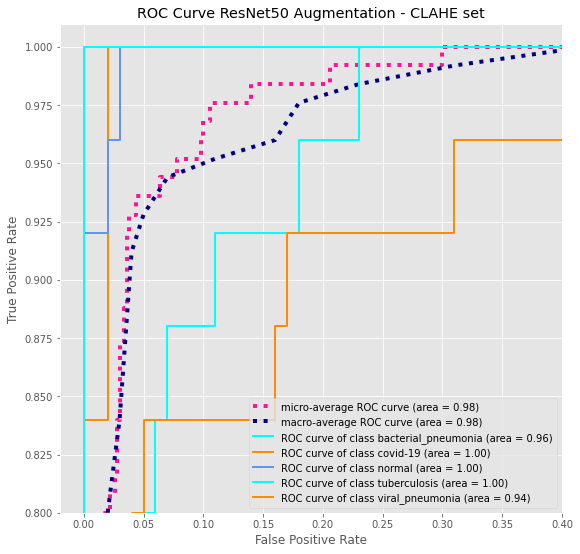

In [ ]:
predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve ResNet50 Augmentation - CLAHE set')

#FineTuning

**FineTuning ResNet50 on CLAHE processed imgs**

In [ ]:
model = load_model('ResNet50 Augmentation CLAHE.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[165:]:
    layer.trainable = True

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned ResNet50 Augmentation CLAHE.h5', verbose=1,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             )

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_255_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE_ft, Y_val_ft))

Epoch 1/100
37/37 [==============================] - 60s 664ms/step - loss: 1.0584 - accuracy: 0.5805 - val_loss: 0.7800 - val_accuracy: 0.6900

Epoch 00001: val_loss improved from inf to 0.78003, saving model to FineTuned ResNet50 Augmentation CLAHE.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 23s 630ms/step - loss: 0.8901 - accuracy: 0.6695 - val_loss: 1.7161 - val_accuracy: 0.4200

Epoch 00002: val_loss did not improve from 0.78003
Epoch 3/100
37/37 [==============================] - 23s 610ms/step - loss: 0.8253 - accuracy: 0.6986 - val_loss: 2.8364 - val_accuracy: 0.3433

Epoch 00003: val_loss did not improve from 0.78003
Epoch 4/100
37/37 [==============================] - 23s 610ms/step - loss: 0.7634 - accuracy: 0.7290 - val_loss: 2.3187 - val_accuracy: 0.4000

Epoch 00004: val_loss did not improve from 0.78003
Epoch 5/100
37/37 [==============================] - 23s 606ms/step - loss: 0.7379 - accuracy: 0.7273 - val_loss: 2.2141 - val_accuracy: 0.4500

Epoch 00005: val_loss did not improve from 0.78003
Epoch 6/100
37/37 [==============================] - 23s 618ms/step - loss: 0.7130 - accuracy: 0.7342 - val_loss: 3.1318 - val_accuracy: 0.3633

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951

In [ ]:
del model
model = load_model('FineTuned ResNet50 Augmentation CLAHE.h5')
final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))


#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")
Y_pred = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 2s 221ms/step - loss: 0.3430 - accuracy: 0.8800
Final Loss: 0.3429827392101288, Final Accuracy: 0.8799999952316284
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.76      0.76      0.76        25
           covid-19       0.96      0.96      0.96        25
             normal       0.89      1.00      0.94        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.77      0.68      0.72        25

           accuracy                           0.88       125
          macro avg       0.88      0.88      0.88       125
       weighted avg       0.88      0.88      0.88       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


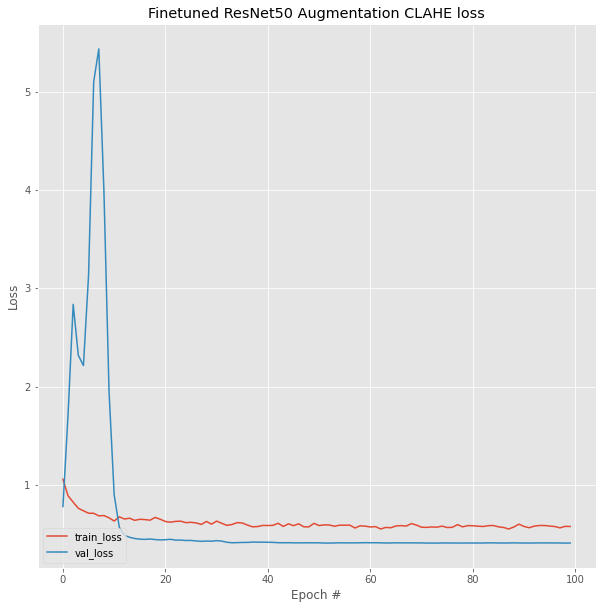

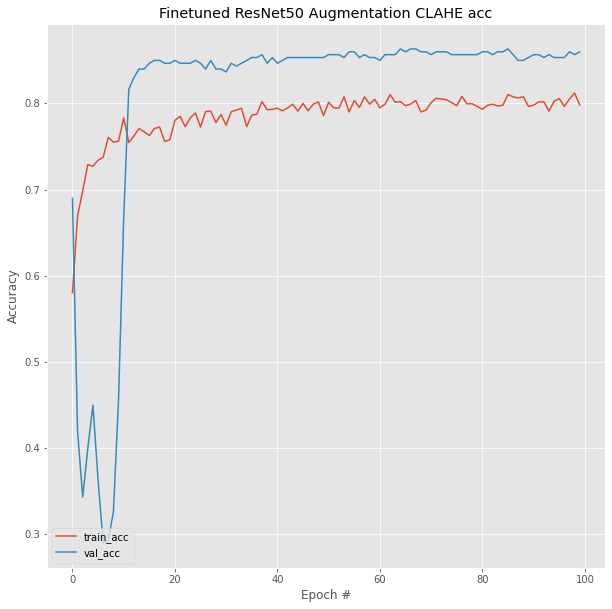

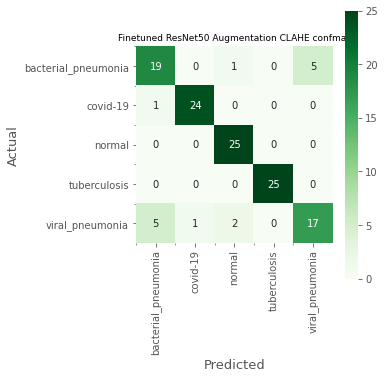

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned ResNet50 Augmentation CLAHE loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned ResNet50 Augmentation CLAHE acc')
plot_confusion_matrix('Finetuned ResNet50 Augmentation CLAHE confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


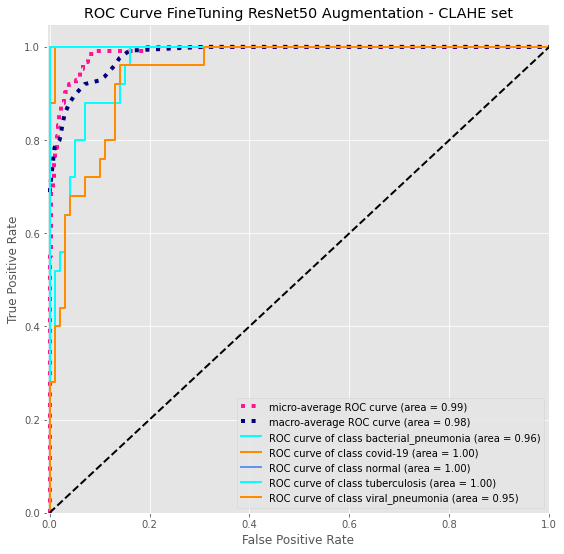

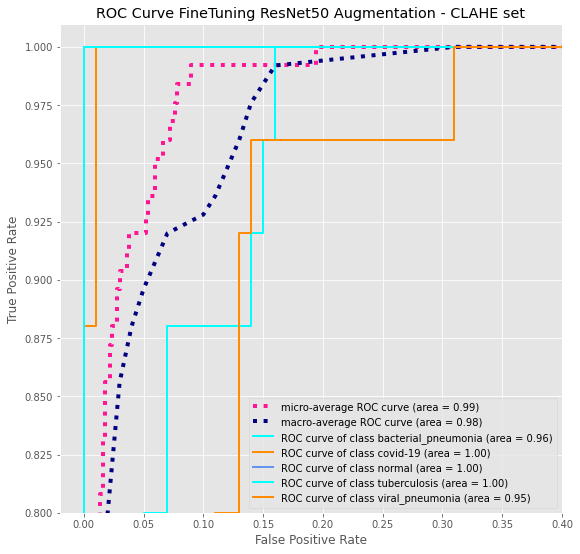

In [ ]:
predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning ResNet50 Augmentation - CLAHE set')

# AUGMENTATION on data normalized to (0-1) + CLAHE processed

**Transfer learning after CLAHE processing imgs**

In [ ]:
del model
model = build_ImageNetModel(ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('ResNet50 Augmentation CLAHE + normalized.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             )  

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE, Y_val))


Epoch 1/100
15/15 [==============================] - 13s 632ms/step - loss: 1.9340 - accuracy: 0.2507 - val_loss: 1.6296 - val_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.62963, saving model to ResNet50 Augmentation CLAHE + normalized.h5
Epoch 2/100
15/15 [==============================] - 8s 553ms/step - loss: 1.7228 - accuracy: 0.3402 - val_loss: 1.5612 - val_accuracy: 0.5040

Epoch 00002: val_loss improved from 1.62963 to 1.56115, saving model to ResNet50 Augmentation CLAHE + normalized.h5
Epoch 3/100
15/15 [==============================] - 8s 549ms/step - loss: 1.5730 - accuracy: 0.3999 - val_loss: 1.5557 - val_accuracy: 0.4480

Epoch 00003: val_loss improved from 1.56115 to 1.55573, saving model to ResNet50 Augmentation CLAHE + normalized.h5
Epoch 4/100
15/15 [==============================] - 8s 550ms/step - loss: 1.4488 - accuracy: 0.4321 - val_loss: 1.5419 - val_accuracy: 0.4960

Epoch 00004: val_loss improved from 1.55573 to 1.54186, saving model to ResNet5

In [ ]:
del model
model = load_model('ResNet50 Augmentation CLAHE + normalized.h5')
final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

Y_pred = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

plot_confusion_matrix('ResNet50 Augmentation CLAHE + normalized confmat',Y_true, Y_pred, categories)

4/4 [==============================] - 9s 2s/step - loss: 0.4390 - accuracy: 0.8320
Final Loss: 0.4389721751213074, Final Accuracy: 0.8320000171661377
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.80      0.80        25
           covid-19       0.92      0.96      0.94        25
             normal       0.71      1.00      0.83        25
       tuberculosis       0.96      0.96      0.96        25
    viral_pneumonia       0.79      0.44      0.56        25

           accuracy                           0.83       125
          macro avg       0.84      0.83      0.82       125
       weighted avg       0.84      0.83      0.82       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


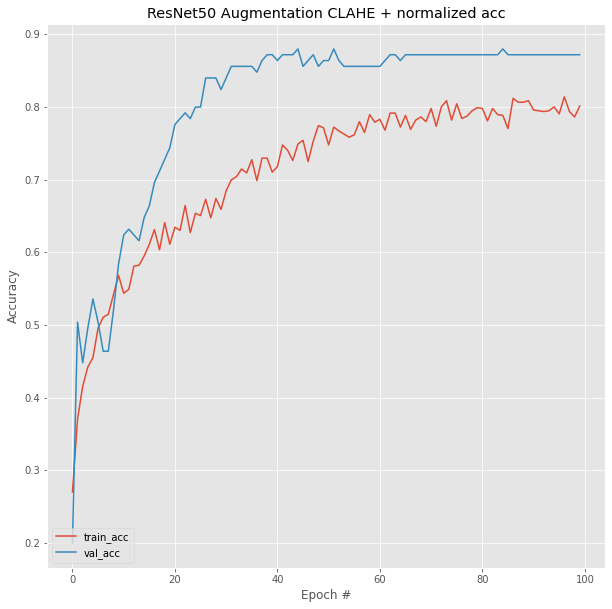

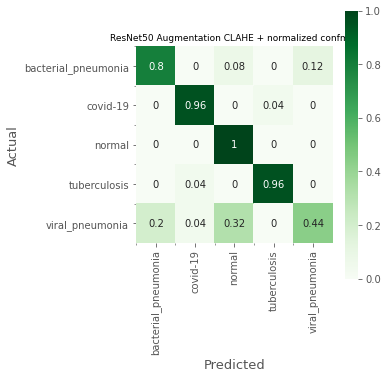

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'ResNet50 Augmentation CLAHE + normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'ResNet50 Augmentation CLAHE + normalized acc')
plot_confusion_matrix('ResNet50 Augmentation CLAHE + normalized confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


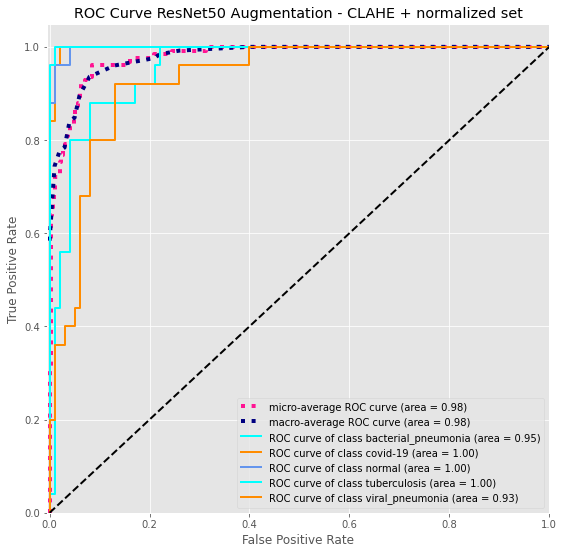

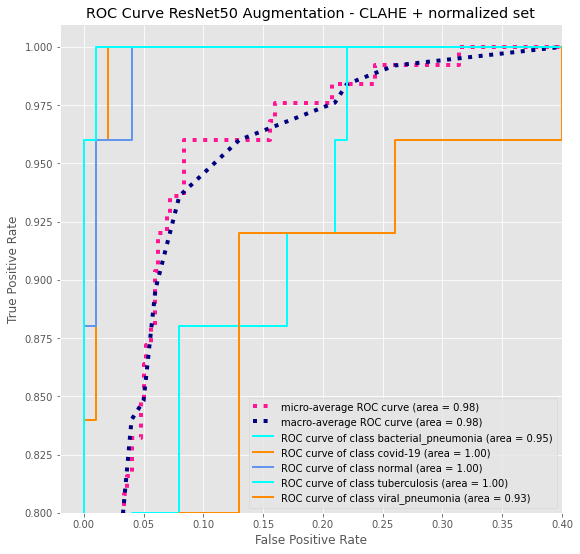

In [ ]:
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve ResNet50 Augmentation - CLAHE + normalized set')

#FineTuning

**FineTuning ResNet50 on CLAHE processed imgs**

In [ ]:
model = load_model('ResNet50 Augmentation CLAHE + normalized.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[165:]:
    layer.trainable = True

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: conv1_pad, trainable: False
layer 2: conv1_conv, trainable: False
layer 3: conv1_bn, trainable: False
layer 4: conv1_relu, trainable: False
layer 5: pool1_pad, trainable: False
layer 6: pool1_pool, trainable: False
layer 7: conv2_block1_1_conv, trainable: False
layer 8: conv2_block1_1_bn, trainable: False
layer 9: conv2_block1_1_relu, trainable: False
layer 10: conv2_block1_2_conv, trainable: False
layer 11: conv2_block1_2_bn, trainable: False
layer 12: conv2_block1_2_relu, trainable: False
layer 13: conv2_block1_0_conv, trainable: False
layer 14: conv2_block1_3_conv, trainable: False
layer 15: conv2_block1_0_bn, trainable: False
layer 16: conv2_block1_3_bn, trainable: False
layer 17: conv2_block1_add, trainable: False
layer 18: conv2_block1_out, trainable: False
layer 19: conv2_block2_1_conv, trainable: False
layer 20: conv2_block2_1_bn, trainable: False
layer 21: conv2_block2_1_relu, trainable: False
layer 22: conv2_block2_2_conv, trainable

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(X_train_CLAHE.shape)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned ResNet50 Augmentation CLAHE + normalized.h5', verbose=1,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             )

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE_ft, Y_val_ft))

(2400, 224, 224, 3)
Epoch 1/100
37/37 [==============================] - 60s 665ms/step - loss: 1.1282 - accuracy: 0.5693 - val_loss: 1.0179 - val_accuracy: 0.6267

Epoch 00001: val_loss improved from inf to 1.01791, saving model to FineTuned ResNet50 Augmentation CLAHE + normalized.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 24s 640ms/step - loss: 0.9527 - accuracy: 0.6507 - val_loss: 1.5622 - val_accuracy: 0.4633

Epoch 00002: val_loss did not improve from 1.01791
Epoch 3/100
37/37 [==============================] - 23s 616ms/step - loss: 0.8369 - accuracy: 0.6901 - val_loss: 2.1254 - val_accuracy: 0.2467

Epoch 00003: val_loss did not improve from 1.01791
Epoch 4/100
37/37 [==============================] - 23s 615ms/step - loss: 0.7864 - accuracy: 0.7192 - val_loss: 2.8413 - val_accuracy: 0.2333

Epoch 00004: val_loss did not improve from 1.01791
Epoch 5/100
37/37 [==============================] - 23s 617ms/step - loss: 0.8089 - accuracy: 0.6918 - val_loss: 3.7312 - val_accuracy: 0.2233

Epoch 00005: val_loss did not improve from 1.01791
Epoch 6/100
37/37 [==============================] - 23s 620ms/step - loss: 0.7687 - accuracy: 0.7200 - val_loss: 4.4772 - val_accuracy: 0.2167

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951

In [ ]:
del model
model = load_model('FineTuned ResNet50 Augmentation CLAHE + normalized.h5')
final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")
Y_pred = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 2s 218ms/step - loss: 0.3845 - accuracy: 0.8640
Final Loss: 0.38450223207473755, Final Accuracy: 0.8640000224113464
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.83      0.80      0.82        25
           covid-19       0.96      0.92      0.94        25
             normal       0.78      1.00      0.88        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.79      0.60      0.68        25

           accuracy                           0.86       125
          macro avg       0.86      0.86      0.86       125
       weighted avg       0.86      0.86      0.86       125



NameError: ignored

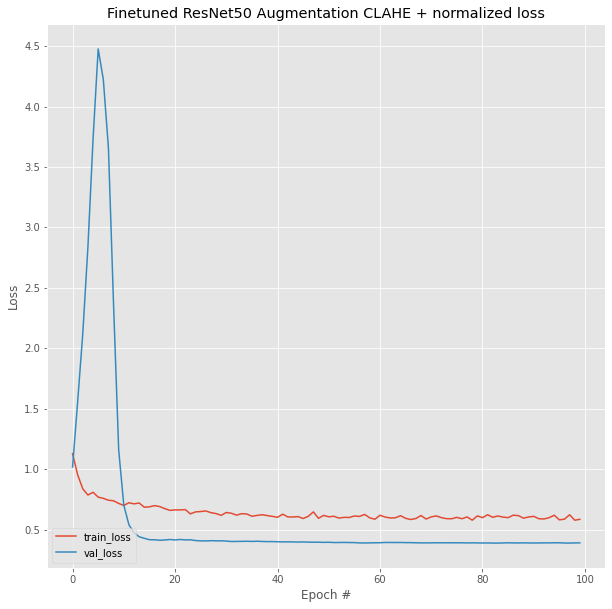

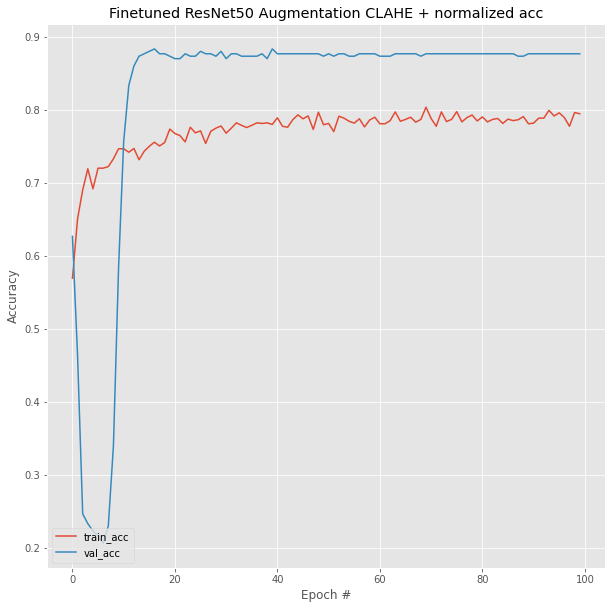

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned ResNet50 Augmentation CLAHE + normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned ResNet50 Augmentation CLAHE + normalized acc')

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


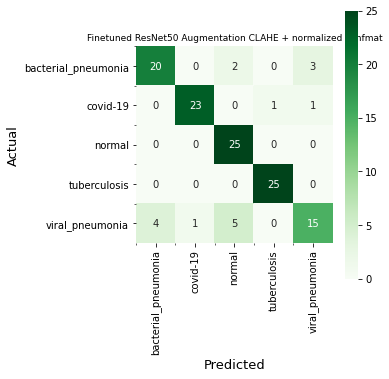

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


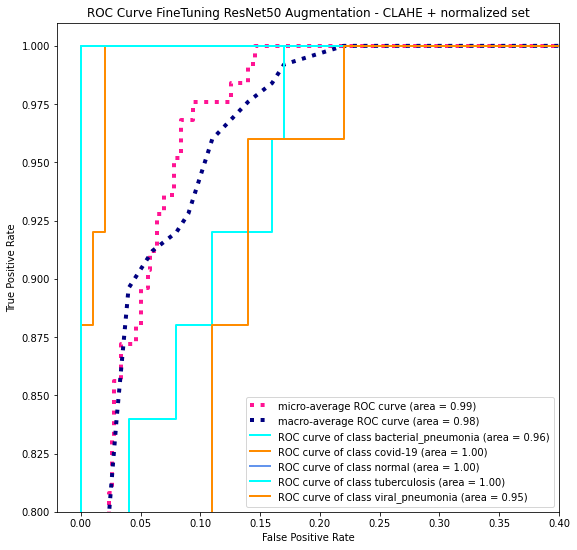

In [ ]:
plot_confusion_matrix('Finetuned ResNet50 Augmentation CLAHE + normalized confmat',Y_true, Y_pred, categories)
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning ResNet50 Augmentation - CLAHE + normalized set')

# Defining and loading Functions for SVM

In [ ]:
pip install daal4py

In [ ]:
import sys
import os
import site
sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [ ]:
from daal4py.sklearn import patch_sklearn
patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1, 1, 7)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
def make_classification(svc, confmat_title, ROC_title, training_title, X_train, y_train, X_test, y_test, cv, kernel, decision_function_shape, verbose, C, with_grid_search, normalize, y_test_ROC):
  from sklearn.metrics import classification_report
  if with_grid_search==True:
    print('Training with parameter GridSearch tuning')
    param = {
      "C": C,
      "kernel": [kernel],
      "decision_function_shape":[decision_function_shape]
    }
    # GridSearchCV for hyperparameters optimization
    clf = GridSearchCV(svc, param, cv=cv, verbose = verbose)
    clf.fit(X_train, y_train)
    print("Best params: ",clf.best_params_)
    print("Best estimator: ", clf.best_estimator_)
    clf = clf.best_estimator_
    y_pred = clf.predict(X_test)
    preds=clf.decision_function(X_test)
    
    print(classification_report(y_test, y_pred, target_names=categories))
    labels = np.unique(y_test)
    print('Loss:', hinge_loss(y_test, preds, labels=labels))
    plot_confusion_matrix(confmat_title, y_test, y_pred, classes = categories, normalize= normalize)
    plt.show()
    plot_ROC_SVM(X_train, y_train, X_test, y_test, preds, len(categories), categories, ROC_title, cv)

    plot_learning_curve(clf, title=training_title, X=X_train, y=y_train, cv=cv)

    return clf
  elif with_grid_search==False:
    print('Training without parameter tuning')
    svc = SVC(verbose = verbose)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    print(y_pred.shape)
    print(classification_report(y_test, y_pred, target_names=categories))
    plot_confusion_matrix(confmat_title, y_test, y_pred, classes = categories, normalize= normalize)
    plt.show()
    plot_ROC_SVM(X_train, y_train, X_test, y_test, svc, len(categories), categories, ROC_title, cv)
    plot_learning_curve(svc, title=training_title, X=X_train, y=y_train, cv=cv)
    return svc

# Feature Extraction and SVM CLASSIFICATION on data divided by 255

**USING SVM CLASSIFIER**

**ImageData / 255**

In [ ]:
del base_model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# Freezing layers in convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape
output_shape

(None, 7, 7, 2048)

In [ ]:
train_features = base_model.predict(X_train_255)
val_features = base_model.predict(X_val_255)
test_features = base_model.predict(X_test_255)

In [ ]:
print(train_features.shape)
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1]*train_features.shape[2]*train_features.shape[3])
print(train_features.shape)

(1000, 7, 7, 2048)
(1000, 100352)


In [ ]:
print(val_features.shape)
val_features = val_features.reshape(val_features.shape[0],val_features.shape[1]*val_features.shape[2]*val_features.shape[3])
print(val_features.shape)

(125, 7, 7, 2048)
(125, 100352)


In [ ]:
print(test_features.shape)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1]*test_features.shape[2]*test_features.shape[3])
print(test_features.shape)

(125, 7, 7, 2048)
(125, 100352)


In [ ]:
print(Y_train.shape)
train_labels = train['Disease Type'].values
test_labels = test['Disease Type'].values
val_labels = val['Disease Type'].values
print(val_labels.shape)

(1000, 5)
(125,)


In [ ]:
train_val_concat_features = np.concatenate((train_features, val_features))
train_val_concat_labels = np.concatenate((train_labels, val_labels))

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.347, total=   8.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.409, total=   7.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.409, total=   7.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.444, total=   8.1s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.400, total=   8.1s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.347, total=   7.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.409, total=   7.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.409, total=   7.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 22.0min finished


Best params:  {'C': 0.01193776641714437, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.01193776641714437, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.81      0.84      0.82        25
           covid-19       0.96      0.96      0.96        25
             normal       0.78      1.00      0.88        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.88      0.60      0.71        25

           accuracy                           0.88       125
          macro avg       0.89      0.88      0.88       125
       weighted avg       0.89      0.88      0.88       125

Loss: 0.26931673582965776
Confusion matrix, without normaliz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


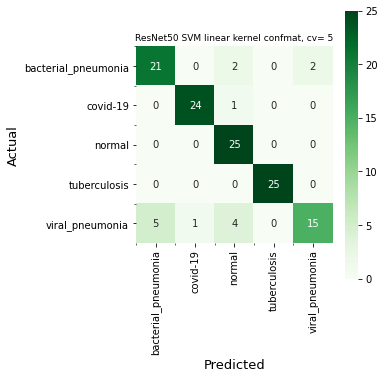

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


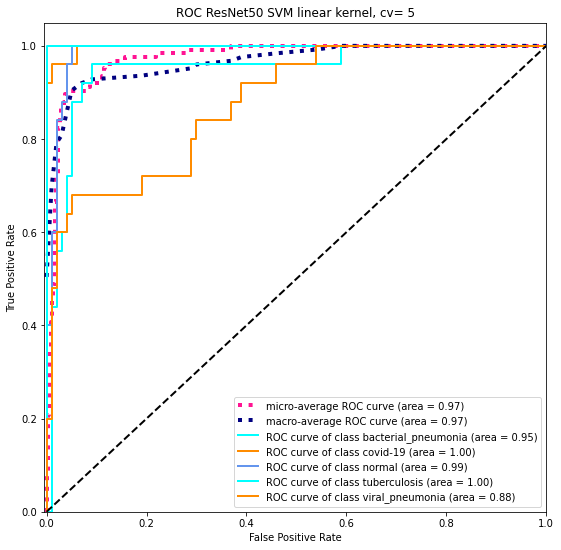

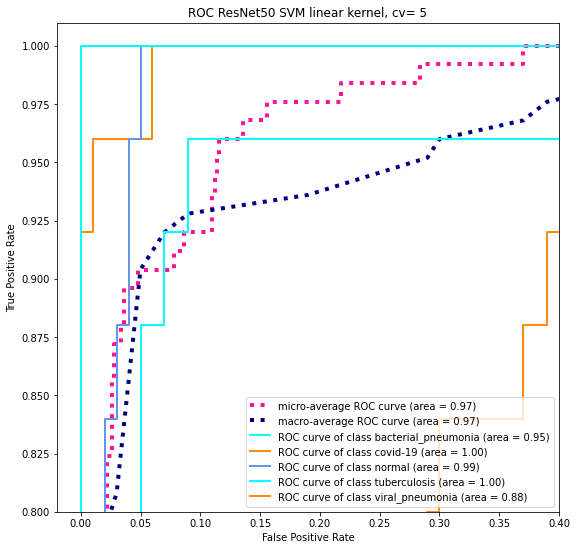

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.01193776641714437, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

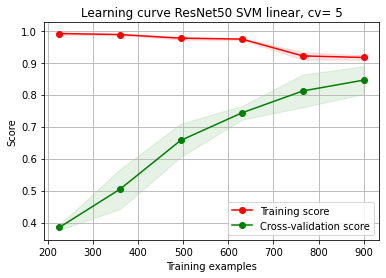

In [ ]:
cv=5
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.397, total=   8.5s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.370, total=   7.6s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.3s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.413, total=   7.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.295, total=   7.6s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.397, total=   7.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.370, total=   7.6s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.413, total=   7.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.295, total=   7.7s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 16.9min finished


Best params:  {'C': 0.017012542798525893, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.017012542798525893, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.81      0.84      0.82        25
           covid-19       0.96      0.92      0.94        25
             normal       0.78      1.00      0.88        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.89      0.64      0.74        25

           accuracy                           0.88       125
          macro avg       0.89      0.88      0.88       125
       weighted avg       0.89      0.88      0.88       125

Loss: 0.26152959963211203
Confusion matrix, without normal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


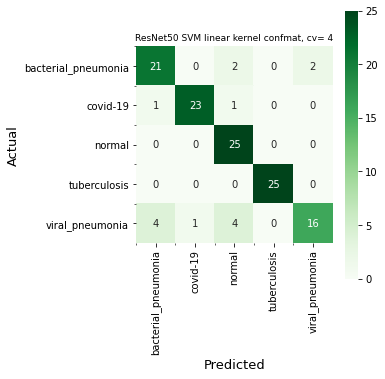

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


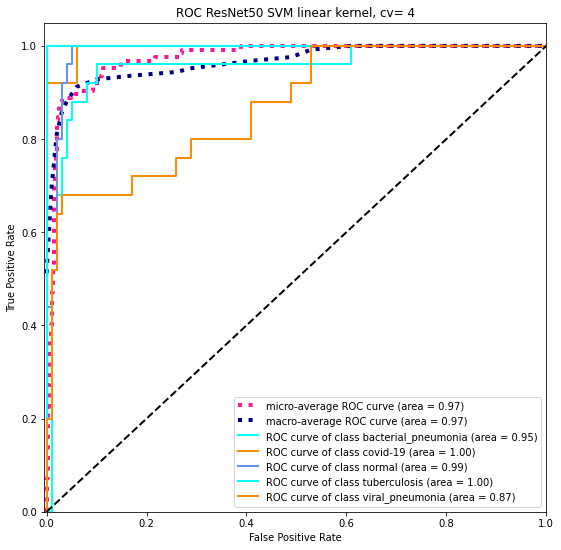

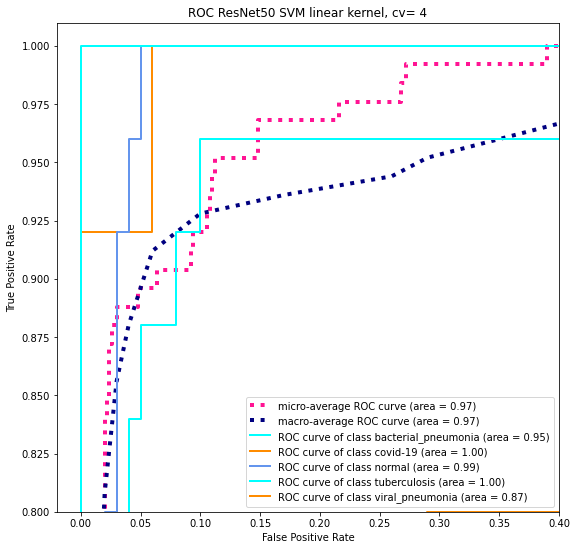

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.017012542798525893, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

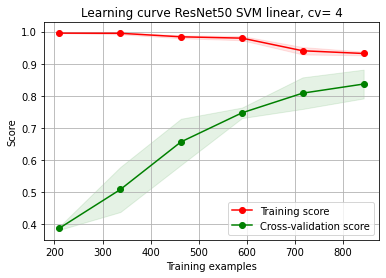

In [ ]:
cv=4
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.421, total=   8.4s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.413, total=   7.3s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.443, total=   7.3s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.421, total=   7.3s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.413, total=   7.3s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.443, total=   7.2s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.421, total=   7.2s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.413, total=   7.2s
[CV] C=2.030917620904734

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 11.8min finished


Best params:  {'C': 0.01193776641714437, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.01193776641714437, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.81      0.84      0.82        25
           covid-19       0.96      0.96      0.96        25
             normal       0.78      1.00      0.88        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.88      0.60      0.71        25

           accuracy                           0.88       125
          macro avg       0.89      0.88      0.88       125
       weighted avg       0.89      0.88      0.88       125

Loss: 0.26931673582965776
Confusion matrix, without normaliz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


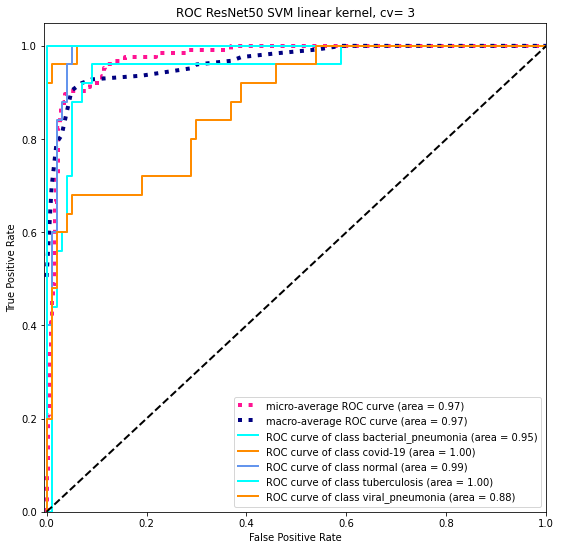

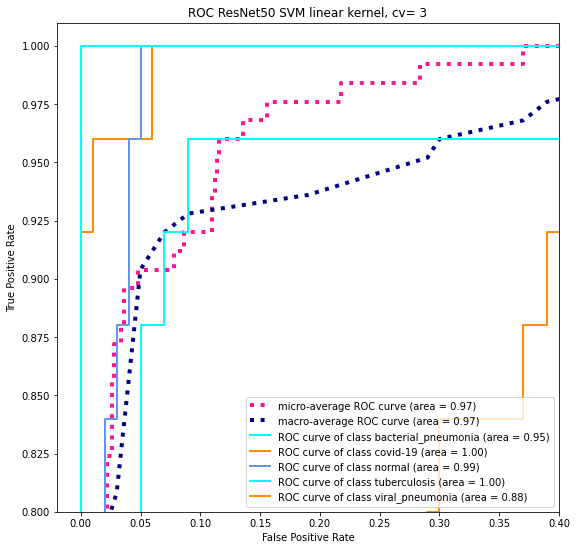

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


SVC(C=0.01193776641714437, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

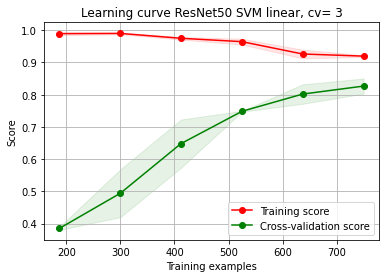

In [ ]:
cv=3
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

# Feature Extraction and SVM CLASSIFICATION on data normalized to (0-1)

In [ ]:
# del base_model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))# Freezing layers in convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape[-1]

print(output_shape)

2048


In [ ]:
del train_features, val_features, test_features
train_features = base_model.predict(X_train)
val_features = base_model.predict(X_val)
test_features = base_model.predict(X_test)

In [ ]:
print(train_features.shape)
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1]*train_features.shape[2]*train_features.shape[3])
print(train_features.shape)

(1000, 7, 7, 2048)
(1000, 100352)


In [ ]:
print(val_features.shape)
val_features = val_features.reshape(val_features.shape[0],val_features.shape[1]*val_features.shape[2]*val_features.shape[3])
print(val_features.shape)

(125, 7, 7, 2048)
(125, 100352)


In [ ]:
print(test_features.shape)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1]*test_features.shape[2]*test_features.shape[3])
print(test_features.shape)

(125, 7, 7, 2048)
(125, 100352)


In [ ]:
del train_labels, test_labels, val_labels
print(Y_train.shape)
train_labels = train['Disease Type'].values
test_labels = test['Disease Type'].values
val_labels = val['Disease Type'].values
print(val_labels.shape)

(1000, 5)
(125,)


In [ ]:
train_val_concat_features = np.concatenate((train_features, val_features))

In [ ]:
train_val_concat_labels = np.concatenate((train_labels, val_labels))

In [ ]:
train_val_concat_features.shape
train_val_concat_labels.shape
np.unique(train_val_concat_labels).shape

(5,)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.356, total=  10.3s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.413, total=   7.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.4s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.440, total=   7.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.471, total=   8.1s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.436, total=   8.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.356, total=   8.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.413, total=   8.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.440, total=   8.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 22.7min finished


Best params:  {'C': 0.07017038286703829, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.07017038286703829, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.85      0.88      0.86        25
           covid-19       1.00      0.96      0.98        25
             normal       0.81      1.00      0.89        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.84      0.64      0.73        25

           accuracy                           0.90       125
          macro avg       0.90      0.90      0.89       125
       weighted avg       0.90      0.90      0.89       125

Loss: 0.2475353984821118
Confusion matrix, without normaliza

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


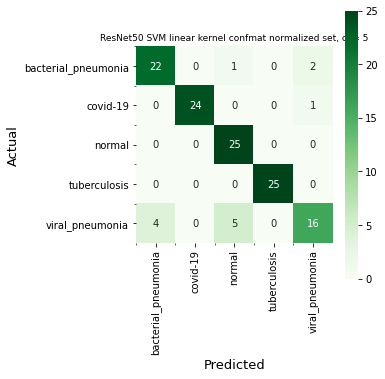

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


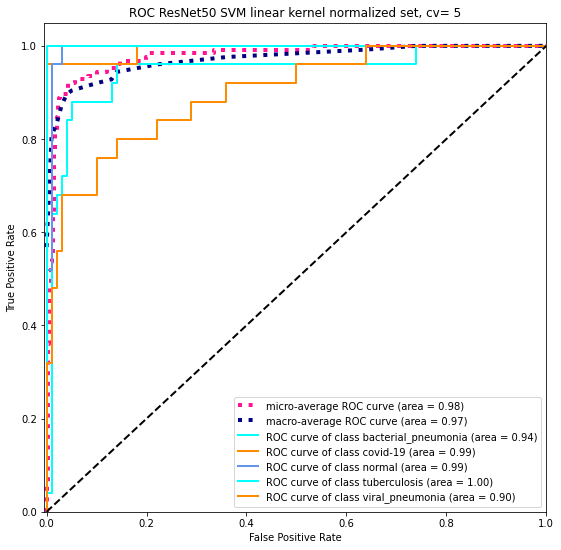

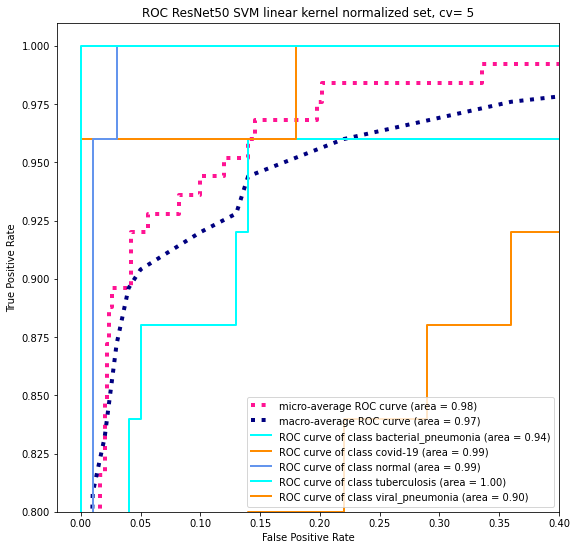

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.07017038286703829, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
cv=5
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat normalized set, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel normalized set, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear normalized set, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.369, total=   8.4s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.413, total=   8.0s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.5s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.434, total=   8.6s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.317, total=   7.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.369, total=   7.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.413, total=   7.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.434, total=   7.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.317, total=   7.9s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 17.5min finished


Best params:  {'C': 0.01193776641714437, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.01193776641714437, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.81      0.84      0.82        25
           covid-19       0.96      0.96      0.96        25
             normal       0.78      1.00      0.88        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.88      0.60      0.71        25

           accuracy                           0.88       125
          macro avg       0.89      0.88      0.88       125
       weighted avg       0.89      0.88      0.88       125

Loss: 0.254154490019024
Confusion matrix, without normalizat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


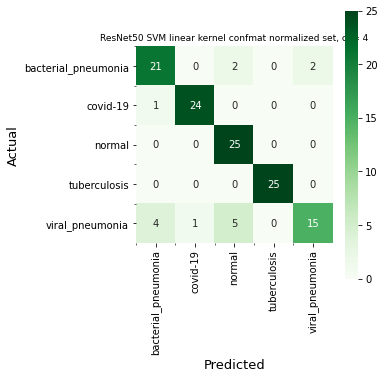

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


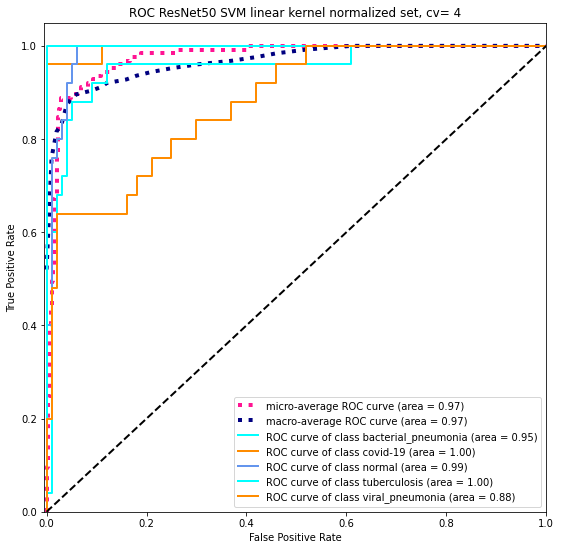

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.01193776641714437, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
cv=4
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat normalized set, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel normalized set, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear normalized set, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

In [ ]:
cv=3
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat normalized set, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel normalized set, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear normalized set, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.408, total=   8.4s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.424, total=   7.5s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.453, total=   7.4s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.408, total=   7.4s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.424, total=   8.1s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.453, total=   8.0s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.408, total=   7.3s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.424, total=   7.4s
[CV] C=2.030917620904734

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 12.1min finished


Best params:  {'C': 0.01193776641714437, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.01193776641714437, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.81      0.84      0.82        25
           covid-19       0.96      0.96      0.96        25
             normal       0.78      1.00      0.88        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.88      0.60      0.71        25

           accuracy                           0.88       125
          macro avg       0.89      0.88      0.88       125
       weighted avg       0.89      0.88      0.88       125

Loss: 0.254154490019024
Confusion matrix, without normalizat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


SVC(C=0.01193776641714437, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

# Feature Extraction and SVM CLASSIFICATION on data divided by 255 + CLAHE processed

In [ ]:
del base_model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# Freezing layers in convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape[-1]

print(output_shape)

In [ ]:
train_features_CLAHE_ = base_model.predict(X_train_255_CLAHE)
val_features_CLAHE_ = base_model.predict(X_val_255_CLAHE)
test_features_CLAHE_ = base_model.predict(X_test_255_CLAHE)

In [ ]:
print(test_features_CLAHE_.shape)

test_features_CLAHE_ = test_features_CLAHE_.reshape(test_features_CLAHE_.shape[0], 7*7*2048)
print(test_features_CLAHE_.shape)

(125, 7, 7, 2048)
(125, 100352)


In [ ]:
print(train_features_CLAHE_.shape)

train_features_CLAHE_ = train_features_CLAHE_.reshape(train_features_CLAHE_.shape[0], 7*7*2048)
print(train_features_CLAHE_.shape)

(1000, 7, 7, 2048)
(1000, 100352)


In [ ]:
print(val_features_CLAHE_.shape)

val_features_CLAHE_ = val_features_CLAHE_.reshape(val_features_CLAHE_.shape[0], 7*7*2048)
print(val_features_CLAHE_.shape)

(125, 7, 7, 2048)
(125, 100352)


In [ ]:
train_labelsCLAHE_ = train['Disease Type'].values
test_labelsCLAHE_ = test['Disease Type'].values
val_labelsCLAHE_ = val['Disease Type'].values

In [ ]:
train_val_concat_features_CLAHE_ = np.concatenate((train_features_CLAHE_, val_features_CLAHE_))

In [ ]:
train_val_concat_labels_CLAHE_ = np.concatenate((train_labelsCLAHE_, val_labelsCLAHE_))

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.471, total=  11.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.560, total=   8.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.587, total=   9.1s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.547, total=   8.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.556, total=   8.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.493, total=   8.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.596, total=   8.4s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.587, total=   8.5s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 22.2min finished


Best params:  {'C': 0.0058780160722749115, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.0058780160722749115, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.80      0.80        25
           covid-19       0.96      0.92      0.94        25
             normal       0.74      1.00      0.85        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.76      0.52      0.62        25

           accuracy                           0.85       125
          macro avg       0.85      0.85      0.84       125
       weighted avg       0.85      0.85      0.84       125

Loss: 0.33481349647213565
Confusion matrix, without norm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


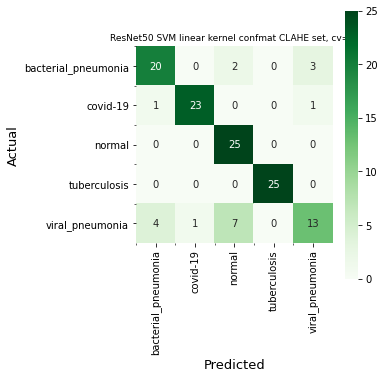

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


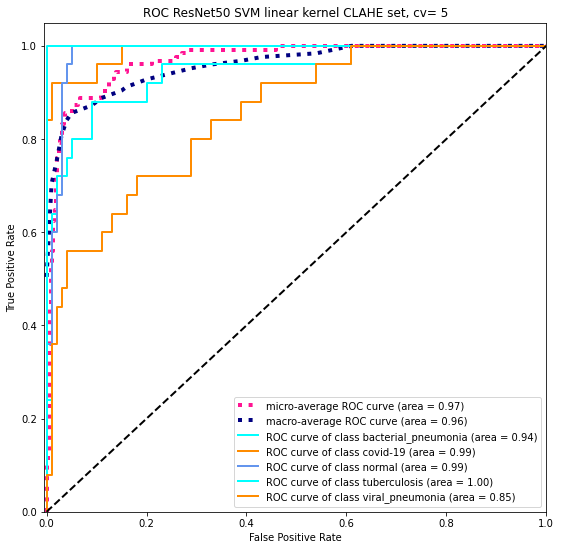

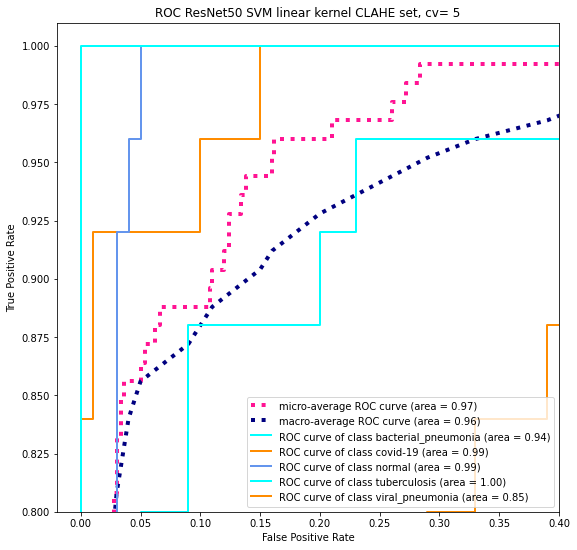

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.0058780160722749115, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

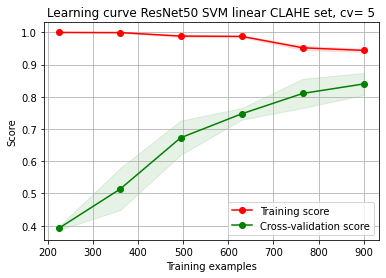

In [ ]:
cv=5
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat CLAHE set, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel CLAHE set, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear CLAHE set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.436, total=   8.5s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.687, total=   8.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.463, total=   7.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.441, total=   8.5s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.447, total=   8.4s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.580, total=   7.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.488, total=   7.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.438, total=   7.7s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 16.6min finished


Best params:  {'C': 0.008376776400682925, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.008376776400682925, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.80      0.80        25
           covid-19       0.96      0.92      0.94        25
             normal       0.75      0.96      0.84        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.74      0.56      0.64        25

           accuracy                           0.85       125
          macro avg       0.85      0.85      0.84       125
       weighted avg       0.85      0.85      0.84       125

Loss: 0.3350717664502138
Confusion matrix, without normali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


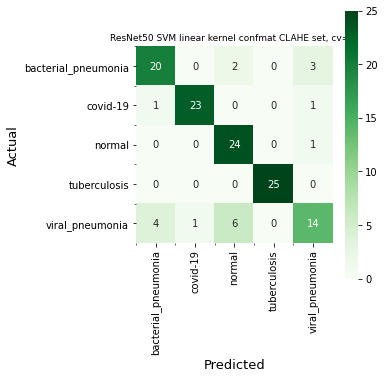

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


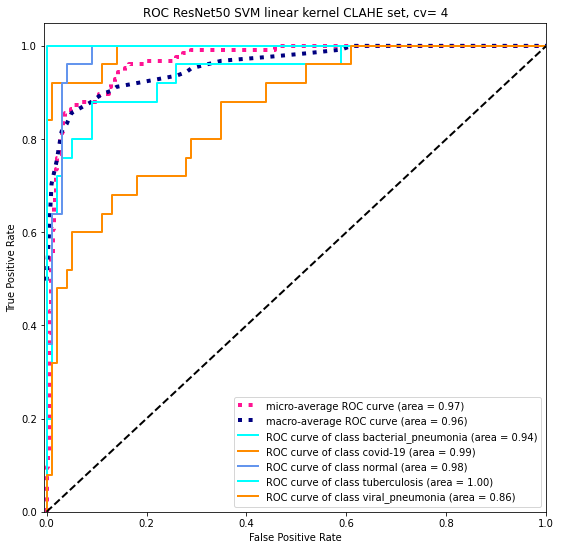

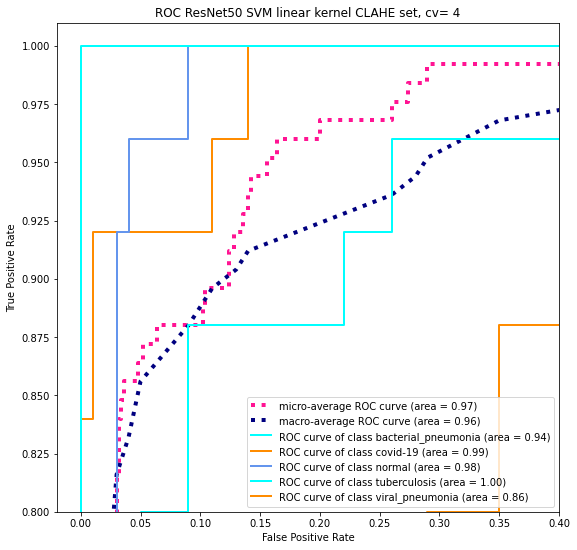

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.008376776400682925, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

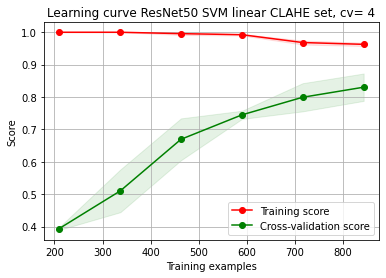

In [ ]:
cv=4
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat CLAHE set, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel CLAHE set, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear CLAHE set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.539, total=  10.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.541, total=   9.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.9s remaining:    0.0s


[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.560, total=   9.4s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.552, total=   9.3s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.539, total=   9.6s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.555, total=   9.6s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.571, total=   9.5s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 12.1min finished


Best params:  {'C': 0.0028942661247167516, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.80      0.80        25
           covid-19       0.96      0.96      0.96        25
             normal       0.74      1.00      0.85        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.81      0.52      0.63        25

           accuracy                           0.86       125
          macro avg       0.86      0.86      0.85       125
       weighted avg       0.86      0.86      0.85       125

Loss: 0.3425202780990076
Confusion matrix, without norma

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


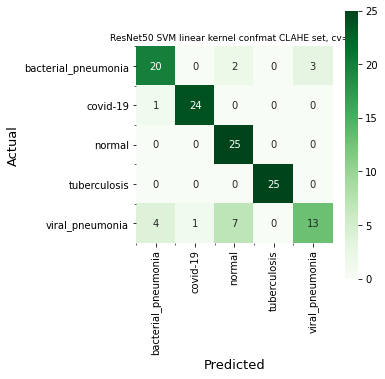

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


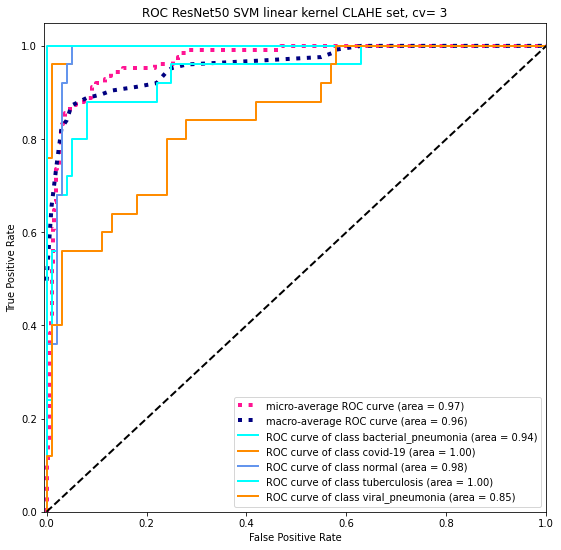

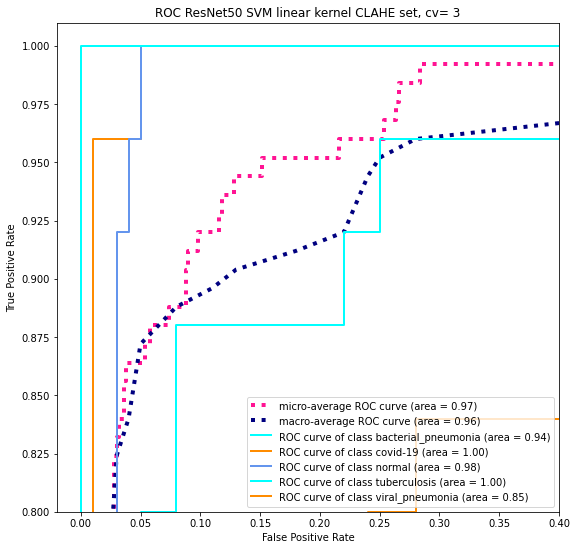

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

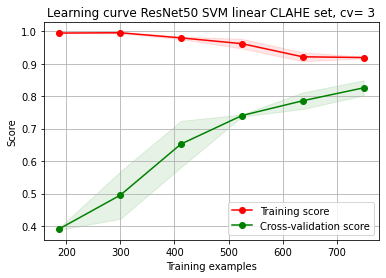

In [ ]:
cv=3
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat CLAHE set, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel CLAHE set, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear CLAHE set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

# Feature Extraction and SVM CLASSIFICATION on data normalized to (0-1) + CLAHE processed

In [ ]:
# del base_model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# Freezing layers in convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape[-1]

print(output_shape)

2048


In [ ]:
del train_features_CLAHE_, val_features_CLAHE_, test_features_CLAHE_
train_features_CLAHE_ = base_model.predict(X_train_CLAHE)
val_features_CLAHE_ = base_model.predict(X_val_CLAHE)
test_features_CLAHE_ = base_model.predict(X_test_CLAHE)

In [ ]:
print(test_features_CLAHE_.shape)

test_features_CLAHE_ = test_features_CLAHE_.reshape(test_features_CLAHE_.shape[0], 7*7*2048)
print(test_features_CLAHE_.shape)

(125, 7, 7, 2048)
(125, 100352)


In [ ]:
print(train_features_CLAHE_.shape)

train_features_CLAHE_ = train_features_CLAHE_.reshape(train_features_CLAHE_.shape[0], 7*7*2048)
print(train_features_CLAHE_.shape)

(1000, 7, 7, 2048)
(1000, 100352)


In [ ]:
print(val_features_CLAHE_.shape)

val_features_CLAHE_ = val_features_CLAHE_.reshape(val_features_CLAHE_.shape[0], 7*7*2048)
print(val_features_CLAHE_.shape)

(125, 7, 7, 2048)
(125, 100352)


In [ ]:
# print(Y_train.shape)

train_labelsCLAHE_ = train['Disease Type'].values
test_labelsCLAHE_ = test['Disease Type'].values
val_labelsCLAHE_ = val['Disease Type'].values
print(val_labelsCLAHE_.shape)
print(train_labelsCLAHE_.shape)
print(test_labelsCLAHE_.shape)

(125,)
(1000,)
(125,)


In [ ]:
# del train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_
train_val_concat_features_CLAHE_ = np.concatenate((train_features_CLAHE_, val_features_CLAHE_))

In [ ]:
train_val_concat_labels_CLAHE_ = np.concatenate((train_labelsCLAHE_, val_labelsCLAHE_))

Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.462, total=  11.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.551, total=   7.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.578, total=   7.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.560, total=   7.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.560, total=   7.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.493, total=   7.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.573, total=   7.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.582, total=   7.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 21.7min finished


Best params:  {'C': 0.002030917620904737, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.002030917620904737, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.80      0.80        25
           covid-19       0.96      0.96      0.96        25
             normal       0.74      1.00      0.85        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.81      0.52      0.63        25

           accuracy                           0.86       125
          macro avg       0.86      0.86      0.85       125
       weighted avg       0.86      0.86      0.85       125

Loss: 0.3350094419229009
Confusion matrix, without normali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


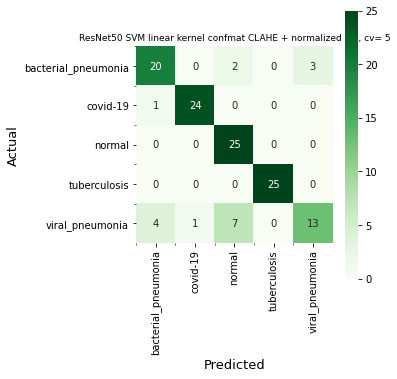

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


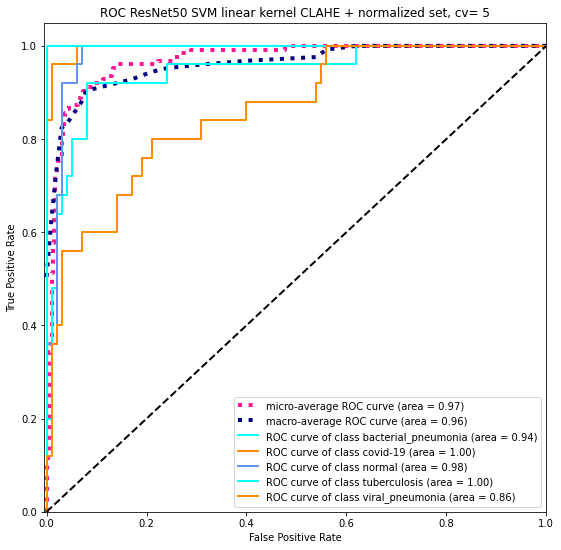

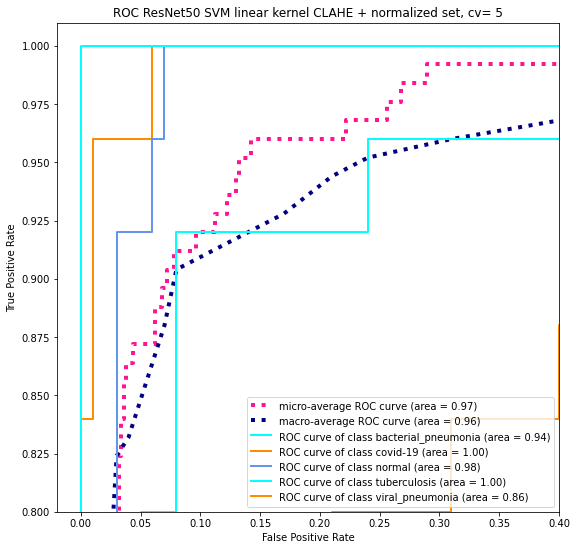

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.002030917620904737, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

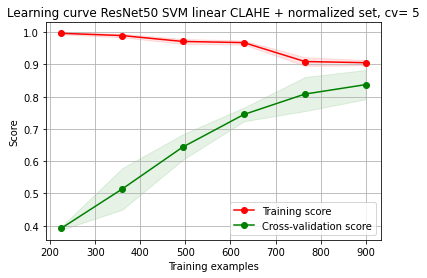

In [ ]:
cv=5
C=np.logspace(-5,1,40)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat CLAHE + normalized set, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel CLAHE + normalized set, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear CLAHE + normalized set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.422, total=   8.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.637, total=   7.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.7s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.470, total=   7.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.438, total=   7.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.454, total=   8.1s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.616, total=   7.6s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.484, total=   7.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.445, total=   7.7s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 16.7min finished


Best params:  {'C': 0.0028942661247167516, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.83      0.80      0.82        25
           covid-19       0.96      0.96      0.96        25
             normal       0.74      1.00      0.85        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.82      0.56      0.67        25

           accuracy                           0.86       125
          macro avg       0.87      0.86      0.86       125
       weighted avg       0.87      0.86      0.86       125

Loss: 0.31833971062921146
Confusion matrix, without norm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


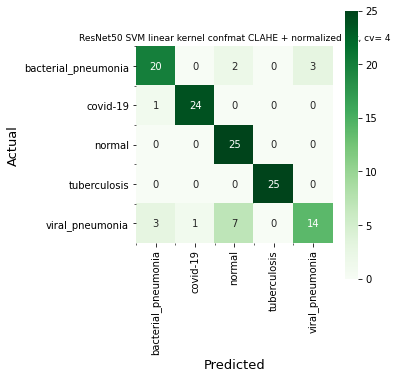

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


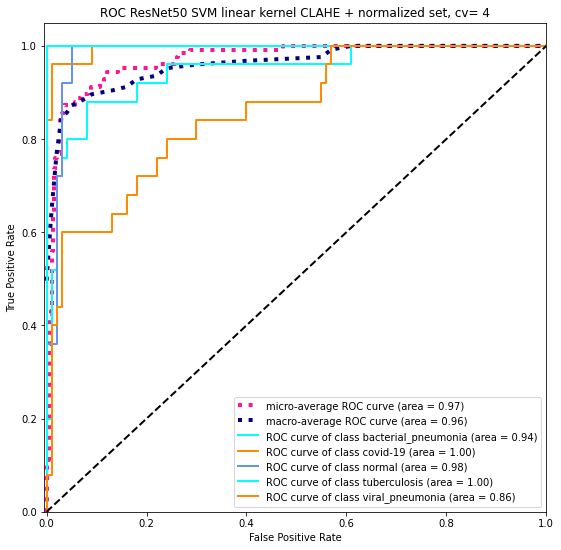

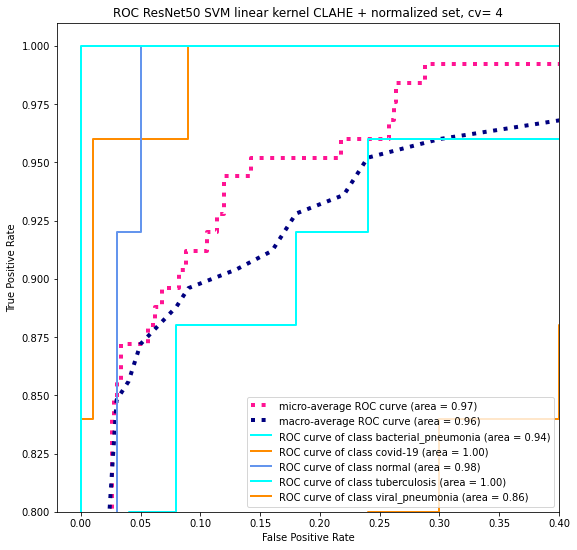

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

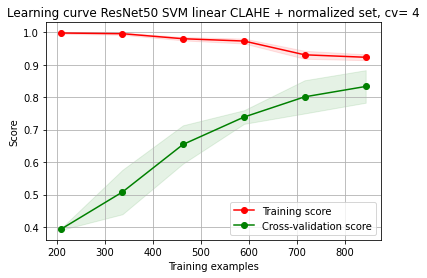

In [ ]:
cv=4
C=np.logspace(-5,1,40)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat CLAHE + normalized set, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel CLAHE + normalized set, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear CLAHE + normalized set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.533, total=   8.3s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.547, total=   7.6s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.552, total=   7.4s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.536, total=   7.5s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.544, total=   7.3s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.539, total=   7.3s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.573, total=   7.3s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.552, total=   7.3s
[CV] C=2.030917620904734

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 11.3min finished


Best params:  {'C': 0.0028942661247167516, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.83      0.80      0.82        25
           covid-19       0.96      0.96      0.96        25
             normal       0.74      1.00      0.85        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.82      0.56      0.67        25

           accuracy                           0.86       125
          macro avg       0.87      0.86      0.86       125
       weighted avg       0.87      0.86      0.86       125

Loss: 0.31833971062921146
Confusion matrix, without norm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


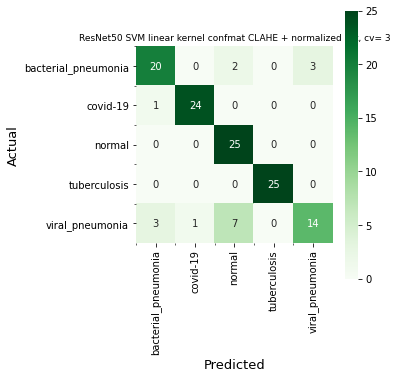

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


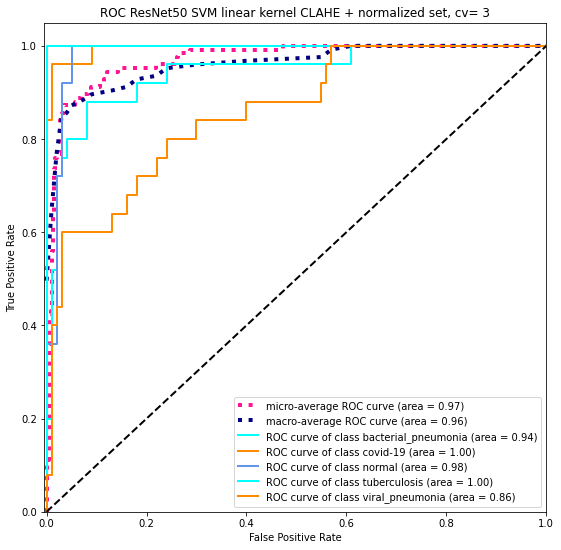

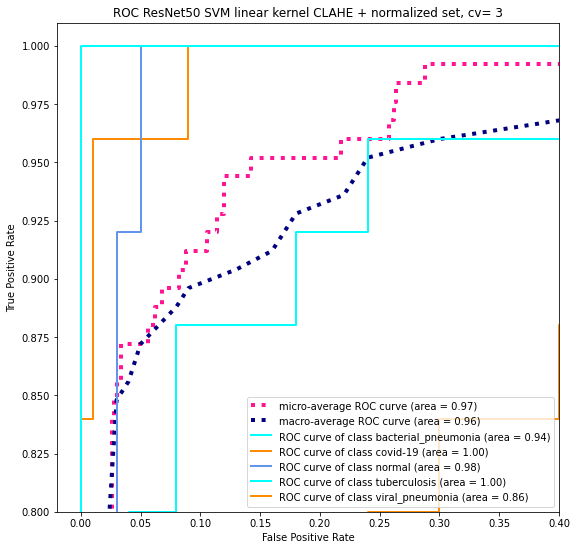

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


SVC(C=0.0028942661247167516, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

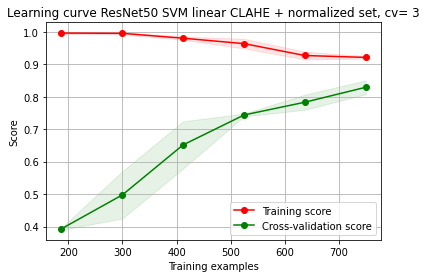

In [ ]:
# del SVC()
del C
cv=3
C=np.logspace(-5,1,40)
make_classification(SVC(), 'ResNet50 SVM linear kernel confmat CLAHE + normalized set, cv= '+str(cv), 
                    'ROC ResNet50 SVM linear kernel CLAHE + normalized set, cv= '+str(cv),
                    'Learning curve ResNet50 SVM linear CLAHE + normalized set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)